# Photometric Event Classification with Time2Vec-Enhanced Transformer

This notebook implements an example of the full pipeline our new Transformer-based photometry classifier, with improved time encoding.  It consists of:

1. Preprocessing (§1): from raw photometry and alerts to a normalized event‐matrix per object.  
2. Model Architecture (§2): a Transformer encoder augmented with a learned Time2Vec embedding.  
3. Self-Supervised Pre-Training (§2.3): reconstructing masked tokens over the first 100 days of each light curve.  
4. Supervised Fine-Tuning (§2.4): optimizing focal loss for classification at variable observation horizons.  
5. Evaluation & Horizon Sweep (§3): plotting Macro-AUPRC, Balanced Accuracy, Top-$k$ and Balanced Top-2 Accuracy as functions of the observation window, to evaluate the early classification capacity.

The hyphothesis is that this two‐stage learning procedure, the long‐horizon unsupervised pre‐training followed by short‐horizon supervised tuning lets the model learn rich temporal patterns over the months time scale while specializing to the early light curve behavior that is most predictive of class. 

---

## 1. Preprocessing

We convert raw measurements $(t_i, f_i, \sigma_{f,i})$ into a fixed‐format event sequence $\mathbf X\in\mathbb R^{T\times F}$ for each object.

### 1.1. Merging Simultaneous Observations

To reduce noise and redundant data, any consecutive measurements separated by $\Delta t \le \delta$ (e.g.\ $\delta=12\,$h) are collapsed via inverse‐variance weighting:
$$
w_i = \frac{1}{\sigma_{f,i} + \varepsilon},\quad
\bar t = \frac{\sum_i w_i\,t_i}{\sum_i w_i},\quad
\bar f = \frac{\sum_i w_i\,f_i}{\sum_i w_i},\quad
\overline{\sigma} = \frac{\sum_i w_i\,\sigma_{f,i}}{\sum_i w_i}.
$$
Here $\varepsilon$ guards against zero error.

### 1.2. Feature-Vector Construction

After sorting by Modified Julian Date (MJD), for each event $n$ we compute
$$
\begin{aligned}
\Delta t_n &= \mathrm{MJD}_n - \mathrm{MJD}_1,\\
\delta t_n &= 
\begin{cases}
\mathrm{MJD}_n - \mathrm{MJD}_{n-1}, & n>1,\\
0, & n=1,
\end{cases}\\
\log f_n &= \log_{10}\bigl(\max(f_n,\,10^{-6})\bigr),\\
\sigma_{\log f,n} &= \frac{\sigma_{f,n}}{f_n\,\ln 10},\\
\mathbf b_n &\in\{0,1\}^3\quad\text{(one-hot for filters $g,r,i$)}.
\end{aligned}
$$
We also compute colour indices by nearest‐time matching:
$$
g-r,\quad r-i
$$
and record masks $\mathbf m_n\in\{0,1\}^2$ indicating which colours are valid.  Although colours are computed, the baseline model omits them from the input and uses only
$$
x_n = \bigl[\log(1 + \Delta t_n),\; \log(1 + \delta t_n),\;\log f_n,\;\sigma_{\log f,n},\;\mathbf b_n,\;\mathbf m_n\bigr]\;\in\;\mathbb R^7.
$$

### 1.3. Dataset Splits & Global Normalization

1. Each object’s spectroscopic type is mapped to an integer $y\in\{1,\dots,C\}$, and object IDs are split into train/val/test (70/15/15 %) while preserving class proportions.  
2. We save for each object a compressed file containing its event‐matrix and label, and build manifest_{split}.csv.  
3. Over all training events (total $N$ rows, $F$ features) we compute
$$
\mu_j = \frac{1}{N}\sum_{n=1}^N X_{n,j},\qquad
\sigma_j = \sqrt{\frac{1}{N}\sum_{n=1}^N\bigl(X_{n,j}-\mu_j\bigr)^2}\,,
$$
which are used to normalize the continuous channels. We compute those statistics for light curves under the same truncation as pretraining.

---

### 2. Model Architecture and Training 

We now describe in detail the architecture of our photometric‐event classifier.  We first normalize the continuous channels:
$$
\tilde x_{n,j} = \frac{x_{n,j}-\mu_j}{\sigma_j},\quad j\in\{ \log(1 + \Delta t), \ \log(1 + \delta t), \ \log f, \ \sigma_{\log f}\},
$$
and then concatenate with the one‐hot band vector $\mathbf b_n$ and mask bits to obtain the final input $\tilde x_n \in\;\mathbb R^7.$  

#### 2.1 Linear Projection & Time2Vec Embedding  

We seek a unified representation of its photometric content and the exact time at which it was observed.  A simple learned affine map lifts $\tilde x_n$ into a $d$-dimensional feature space:  
$$
e_n \;=\; W_{\mathrm{in}}\,\tilde x_n \;+\; b_{\mathrm{in}}
\;\in\;\mathbb R^d.
$$  
In standard NLP and vision applications, one then adds fixed “sinusoidal” positional encodings to $e_n$ to recover order information.  However, those encodings assume a uniform, discrete index $n$ rather than the irregular, object-dependent timestamps of astronomical surveys.  To address this, we introduce a Time2Vec module, which learns a continuous, data-driven embedding of the elapsed time $\Delta t_n $. we parametrize  
$$
\tau_n
\;=\;\bigl[v_n^{(0)},\,v_n^{(1)},\,\dots,\,v_n^{(d-1)}\bigr]^\top
\;\in\;\mathbb R^d
$$  
with  
$$
\begin{aligned}
v_n^{(0)} &= w_0\,\Delta t_n + b_0,\\
v_n^{(i)} &= \sin\bigl(w_i\,\Delta t_n + b_i\bigr)
\quad\text{for } i=1,\dots,d-1.
\end{aligned}
$$  
Here the linear component $(w_0,b_0)$ captures broad, monotonic trends in flux or colour over time, while the sinusoidal components $(w_i,b_i)_{i\ge1}$ learn arbitrary periodicities or quasi-periodic patterns,something fixed encodings cannot adaptively model. Finally, we simply add these two streams of information to form the initial hidden representation  
$$
h_n^{(0)} \;=\; e_n \;+\; \tau_n,
$$  
this joint embedding $\{h_n^{(0)}\}_{n=1}^T$ is then passed directly into the Transformer encoder described next.  


#### 2.2 Transformer Encoder  
We prepend a learned “CLS” token $h_\mathrm{CLS}^{(0)}\in\mathbb R^d$ to the sequence, yielding
$\bigl[h_\mathrm{CLS}^{(0)},\,h_1^{(0)},\,\dots,\,h_T^{(0)}\bigr]\in\mathbb R^{(T+1)\times d}.$
Let $H^{(\ell)}\in\mathbb R^{(T+1)\times d}$ denote the outputs after $\ell$ encoder layers.  Each layer comprises:
1. Multi‐Head Self‐Attention:  
   $$
   \mathrm{MHSA}(Q,K,V)
   = \bigl[\mathrm{softmax}(QK^\top/\sqrt{d_k})\,V\bigr]W_O,
   $$
   with $Q,K,V=W_QH^{(\ell-1)},\,W_KH^{(\ell-1)},\,W_VH^{(\ell-1)}$.
2. Position‐Wise Feed‐Forward:  
   $$
   \mathrm{FFN}(z) = W_2\,\mathrm{ReLU}(W_1\,z + b_1) + b_2.
   $$
3. Residual & Layer‐Norm before and after each sub‐layer.

The encoder produces hidden states
$$
H^{(\ell)} = \mathrm{TransformerEncoder}\bigl(\{\tilde x_n\}\bigr)\in\mathbb R^{T\times d}.
$$


#### 2.3 Self‐Supervised Pre‐Training on 100 d Light Curves

Before we ever see a classification label, we “warm up” the Transformer encoder on unlabeled light‐curve fragments spanning the first 100 days of each object.  For each training object we truncate its event sequence to the first $T_{100}$ events with $\Delta t_n \le 100$ days, normalize as in §2.1, and construct mini‐batches $\{x_n\}_{n=1}^{T_{100}}$.  On each batch we randomly mask a fraction $p$ of the photometric channels (flux, flux‐error, band one-hot), producing masked inputs $\tilde x_n^{\mathrm{mask}}$.  In this time window, the encoder produces hidden states
$
\mathrm{TransformerEncoder}\bigl(\{\tilde x_n^{\mathrm{mask}}\}\bigr)\in\mathbb R^{T_{100}\times d}.
$
We discard the CLS token here and focus on per‐token reconstructions: for each position $n$ that was masked, we predict
$$
\hat f_n,\;\hat b_n,\;\widehat{\delta t}_n
$$
via three small linear heads on the corresponding hidden vector.  The pre‐training loss on one batch is
$$
\mathcal L_{\mathrm{PT}}
= \lambda_F\,\frac{1}{|\mathcal M|}\sum_{n\in\mathcal M}(f_n-\hat f_n)^2
\;+\;\lambda_B\,\frac{1}{|\mathcal M|}\sum_{n\in\mathcal M}\mathrm{CE}\bigl(b_n,\hat b_n\bigr)
\;+\;\lambda_{\delta t}\,\frac{1}{|\mathcal M|}\sum_{n\in\mathcal M}(\delta t_n-\widehat{\delta t}_n)^2,
$$
where $\mathcal M$ indexes masked positions.  We train for $E_{\mathrm{PT}}$ epochs with AdamW and cosine‐annealing learning rate, saving the encoder weights $W_{\mathrm{enc}}^{*}$ at convergence.

#### 2.4 Supervised Fine‐Tuning on Variable Horizons

After pre-training on the first 100 d of each light curve, we specialize the model to the classification task at shorter “observation horizons” $H_t\le100\,$d.  For a given horizon $H_t$ we:

1. Truncate each object’s event sequence to those with $\Delta t_n \le H_t$, yielding $T_{H_t}$ tokens per object.  
2. Normalize & Embed exactly as in §2.1, then pass through the Transformer encoder initialized with the pre-trained weights $W_{\mathrm{enc}}^*$, to obtain
$$
H^{(\ell)} = \mathrm{TransformerEncoder}\bigl(\{\tilde x_n\}\bigr)\in\mathbb R^{T_{H_t}\times d}.
$$ 
3. Classify by extracting the CLS token output,
$$
z_\mathrm{CLS} = H^{(\ell)}_{0}\in\mathbb R^d,
$$
applying LayerNorm and a final linear head to produce class logits
   $$
   \hat y_i \;=\; W_{\mathrm{head}}\;\mathrm{LayerNorm}(z_{\mathrm{CLS}})\;+\;b_{\mathrm{head}}
   \;\in\;\mathbb R^C.
   $$  

where $C$ is the number of classes.

We minimize the standard focal loss over the batch of $N_{H_t}$ examples:  
$$
\mathcal L_{\mathrm{focal}}
= -\frac{1}{N_{H_t}} \sum_{i=1}^{N_{H_t}}
\bigl(1 - p_{i,y_i}\bigr)^\gamma \,\ln p_{i,y_i},
\quad
p_{i,c} = \mathrm{softmax}(\hat y_i)_c,
$$  
where $\gamma$ is the focusing parameter. To study the best adaptation strategy, we compare two fine-tuning regimes:

1. Full Fine-Tuning  
   All model parameters (both encoder and head) are updated simultaneously with a single learning rate $\eta_{\mathrm{full}}$.  This allows the entire network to adapt to the classification task at horizon $H_t$, but risks “forgetting” some of the rich temporal features learned during pre-training.

2. Head-Then-Unfreeze  
   - Stage 1 (Head-Only): Freeze the Transformer encoder (keep $W_{\mathrm{enc}}^*$ fixed) and train only the classification head for a few epochs with a higher learning rate $\eta_{\mathrm{head}}$.  This quickly aligns the head to the target classes without disturbing the encoder.  
   - Stage 2 (Unfreeze All): Unfreeze the entire model.  Continue training with a differential learning rate schedule: a smaller rate $\eta_{\mathrm{enc}}$ for the encoder to preserve pre‐trained features, and a larger rate $\eta_{\mathrm{head}}$ for the head to refine decision boundaries.

Both strategies use AdamW optimization, early stopping on validation macro-AUPRC, and checkpoint the best weights for downstream evaluation.  

---

## 3. Evaluation & Horizon Sweep on Test Set

To quantify how performance degrades as we shorten the available light-curve window, we evaluate our fine-tuned models on the held-out test set for each observation horizon $H \in [1, H_{t}]$. 
For each horizon $H$, we truncate every object to $\Delta t_n \le H$ and compute the following summary metrics:

1. Macro-AUPRC  
   We compute the area under the precision–recall curve independently for each class and then average:
   $$
   \mathrm{AUPRC}_{\mathrm{macro}}
   = \frac{1}{C}\sum_{c=1}^C \mathrm{AP}_c,
   $$
   where $\mathrm{AP}_c$ is the average precision for class $c$.  This metric captures the model’s ability to balance precision and recall across all classes, and is especially informative under class imbalance.

2. Balanced Accuracy  
   We measure recall (true‐positive rate) per class, then average:
   $$
   \mathrm{BalAcc}
   = \frac{1}{C}\sum_{c=1}^C \frac{\mathrm{TP}_c}{\mathrm{TP}_c + \mathrm{FN}_c}\,.
   $$
   Unlike standard accuracy, this treats each class equally and is robust to imbalanced priors.

3. Top-$k$ Accuracy  
   We check whether the true label $y_i$ lies among the $k$ highest-probability predictions:
   $$
   \mathrm{Top}\!-\!k
   = \frac{1}{N}\sum_{i=1}^N \mathbf{1}\bigl[y_i \in \mathrm{top}_k(\hat p_i)\bigr].
   $$
   By default we report $k=2$, which reflects the model’s ability to include the correct class in its top two guesses.

4. Balanced Top-2 Accuracy  
   To combine the fairness of balanced accuracy with the flexibility of top-2 predictions, we compute per-class Top-2 recall and then average:
   $$
   \mathrm{BalTop2}
   = \frac{1}{C}\sum_{c=1}^C
     \frac{1}{N_c}\sum_{i:y_i=c}
       \mathbf{1}\bigl[y_i \in \mathrm{top}_2(\hat p_i)\bigr],
   $$
   where $N_c$ is the number of test examples of class $c$.  This metric answers, “On average, how often is the true class among the model’s two highest-confidence predictions for each class?”

By plotting each metric against the observation horizon $H$, we trace how performance evolves as more of the light curve becomes available. The Top-1 and Top-2 accuracy curves show how quickly the model “locks in” the correct class once enough data has been seen. The Balanced Accuracy and Balanced Top-2 curves reveal the model’s fairness across all classes, ensuring that rare transients are not overlooked. Meanwhile, the Macro-AUPRC curve encapsulates the precision-recall trade-off across every class, indicating how well the model distinguishes signal from noise at each horizon. We can use this analysis to diagnose the best operating point for the production version of the model.


In [1]:
import os

In [2]:
os.listdir('/work/hdd/bcrv/ffontinelenunes/data/AppleCider/photo_events')

['feature_stats_day100.npz',
 'val',
 'splits.csv',
 '.ipynb_checkpoints',
 'test',
 'train',
 'photo_t2vec_transformer_classifier_clean.ipynb',
 'feature_stats_day10.npz',
 'manifest_val.csv',
 'manifest_train.csv',
 'manifest_test.csv']

In [2]:
# ===============================================================
# Imports & global knobs -------------------------------------
# ===============================================================
import os, math, time
import numpy as np, pandas as pd, torch
import torch.nn as nn, torch.nn.functional as F
import wandb
import matplotlib.pyplot as plt, seaborn as sns

from pathlib import Path
from types   import SimpleNamespace
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
from tqdm.auto import tqdm

from sklearn.preprocessing    import label_binarize
from sklearn.metrics          import (
    average_precision_score, roc_auc_score,
    precision_score, recall_score, f1_score, fbeta_score,
    top_k_accuracy_score, roc_curve,
    precision_recall_curve, confusion_matrix,
    classification_report
)
from matplotlib.ticker        import AutoMinorLocator
from matplotlib               import cm as _cm
from collections import Counter

# -------- configuration  -----------------------------------------
CFG = SimpleNamespace(
    # data --------------------------------------------------------
    output_dir     = '/work/hdd/bcrv/ffontinelenunes/data/AppleCider/photo_events',
    stats_file     = 'feature_stats_day100.npz',
    horizon_days   = 50.0, # <- fine-tuning on 50 days
    batch_size     = 256, #64,
    sampler_balance= True,
    num_workers    = 8,
    # model -------------------------------------------------------
    d_model        = 128,
    n_heads        = 8,#4,
    n_layers       = 4,#2,
    dropout        = 0.30,
    max_len        = 257,#300,#256,#128,#128,
    # optimiser ---------------------------------------------------
    lr             = 5e-6,
    weight_decay   = 1e-2,
    # loss & imbalance -------------------------------------------
    focal_gamma    = 2.0,
    # augmentation -----------------------------------------------
    cut_time_p     = None, #(.25,.25,.25,.25), #None,  # or (.25,.25,.25,.25)
    p_dropout      = 0.1,
    jitter_scale   = 0.10,
    flux_nu        = 8,    
    # training schedule ------------------------------------------
    epochs         = 150,
    patience       = 30,
    # misc --------------------------------------------------------
    seed           = 42
)

torch.manual_seed(CFG.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ===============================================================
#     Taxonomy  -------------------------------------------------
# ===============================================================
BROAD_CLASSES = ["SNI", "SNII", "Cataclysmic", "AGN", "TDE"]
ORIG2BROAD = {
    "SN Ia":"SNI","SN Ib":"SNI","SN Ic":"SNI",
    "SN II":"SNII","SN IIP":"SNII","SN IIn":"SNII","SN IIb":"SNII",
    "Cataclysmic":"Cataclysmic","AGN":"AGN","Tidal Disruption Event":"TDE",
}
NUM_CLASSES = len(BROAD_CLASSES)
BROAD2ID = {c:i for i,c in enumerate(BROAD_CLASSES)}
_SUBCLASS_ID2NAME = [
    "SN Ia","SN Ib","SN Ic","SN II","SN IIP","SN IIn","SN IIb",
    "Cataclysmic","AGN","Tidal Disruption Event"
]
ID2BROAD_ID = {i:BROAD2ID[ORIG2BROAD[name]] 
               for i,name in enumerate(_SUBCLASS_ID2NAME)}

# ===============================================================
#     Dataset / collate  ----------------------------------------
# ===============================================================
_BAND_OH = np.eye(3, dtype=np.float32)
def build_event_tensor(arr):                    
    dt  = np.log1p(arr[:,0]);  dt_prev = np.log1p(arr[:,1])
    logf, logfe = arr[:,3], arr[:,4]
    oh   = _BAND_OH[arr[:,2].astype(np.int64)]
    vec4 = np.stack([dt, dt_prev, logf, logfe], 1)
    return torch.from_numpy(np.concatenate([vec4, oh], 1))

class PhotoEventDataset(Dataset):
    def __init__(self, manifest_df, horizon=10.0):
        self.df, self.horizon = manifest_df.reset_index(drop=True), horizon
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        raw = np.load(row.filepath)
        arr = raw['data'] if isinstance(raw, np.lib.npyio.NpzFile) else raw
        if self.horizon:
            arr = arr[arr[:,0] <= self.horizon]
        return build_event_tensor(arr.astype(np.float32)), ID2BROAD_ID[int(row.label)]

def load_stats(path):
    st = np.load(path)
    return (torch.from_numpy(st['mean']),
            torch.from_numpy(st['std']))

def build_collate(mean, std):
    def collate(batch):
        seqs, labels = zip(*batch)
        lens = [s.size(0) for s in seqs]
        pad  = pad_sequence(seqs, batch_first=True)
        mask = torch.stack([
            torch.cat([torch.zeros(l), torch.ones(pad.size(1)-l)])
            for l in lens
        ]).bool()
        cont = (pad[...,:4] - mean) / (std + 1e-8)
        return torch.cat([cont, pad[...,4:]], -1), torch.tensor(labels), mask
    return collate

# ===============================================================
#    Model  -----------------------------------------------------
# ===============================================================

# ------------------------------------------------------------------------------
# (NEW) Time2Vec positional encoding
# ------------------------------------------------------------------------------
class Time2Vec(nn.Module):
    """
    Time2Vec: map scalar time t -> d_model-dimensional vector.
    v0 = w0 * t + b0  (linear)
    v[i] = sin(w[i] * t + b[i])  for i=1..d_model-1
    """
    def __init__(self, d_model):
        super().__init__()
        # one linear + (d_model-1) periodic features
        self.w0 = nn.Parameter(torch.randn(1))
        self.b0 = nn.Parameter(torch.zeros(1))
        self.w  = nn.Parameter(torch.randn(d_model-1))
        self.b  = nn.Parameter(torch.zeros(d_model-1))

    def forward(self, t):
        """
        t: (B, L)  - scalar "time since first detection" per event
        returns (B, L, d_model)
        """
        # linear term
        v0 = self.w0 * t + self.b0                          # (B, L)
        # periodic terms
        vp = torch.sin(t.unsqueeze(-1) * self.w + self.b)   # (B, L, d_model-1)
        return torch.cat([v0.unsqueeze(-1), vp], dim=-1)    # (B, L, d_model)

# ------------------------------------------------------------------------------
# (NEW) Transformer Encoder + class token  
# ------------------------------------------------------------------------------
class BaselineCLS(nn.Module):
    def __init__(self, d_model, n_heads, n_layers,
                 num_classes, dropout, max_len=None):
        super().__init__()
        self.in_proj  = nn.Linear(7, d_model)
        self.cls_tok  = nn.Parameter(torch.zeros(1,1,d_model))
        
        # replace SinCos PE with Time2Vec on the dt channel
        
        self.time2vec = Time2Vec(d_model)
        enc_layer      = nn.TransformerEncoderLayer(
                            d_model, n_heads, d_model*4,
                            dropout, batch_first=True)
        self.encoder  = nn.TransformerEncoder(enc_layer, n_layers)
        self.norm     = nn.LayerNorm(d_model)
        self.head     = nn.Linear(d_model, num_classes)

    def forward(self, x, pad_mask):
        """
        x: (B, L, 7)  - the raw event tensor from build_event_tensor
            channels: [ dt, dt_prev, logf, logfe, one-hot-band(3) ]
        pad_mask: (B, L) boolean
        """
        B,L,_ = x.shape

        # project into model dim
        h = self.in_proj(x)                     # (B, L, d_model)
        # extract the *continuous* log1p dt feature
        t = x[..., 0]                           # (B, L)

        # compute the learned time embedding:
        te = self.time2vec(t)                  # (B, L, d_model)

        # add it:
        h = h + te                              # (B, L, d_model)

        # prepend a learned CLS token:
        tok = self.cls_tok.expand(B,-1,-1)      # (B,1,d_model)
        h   = torch.cat([tok, h], dim=1)        # (B, L+1, d_model)

        # adjust padding mask to account for CLS at idx=0
        pad = torch.cat(
            [torch.zeros(B,1,device=pad_mask.device, dtype=torch.bool),
             pad_mask], dim=1
        )

        # encode
        z = self.encoder(h, src_key_padding_mask=pad)  # (B, L+1, d_model)

        # classification from the CLS token
        return self.head(self.norm(z[:,0]))            # (B, num_classes)


Device: cuda


# Self-supervised Masked-Event Pre-Training (ME-MPT) with Time2Vec

In [3]:
# -----------------------------------------------------------------------------
#     Self-supervised Masked-Event Pre-Training (ME-MPT) with Time2Vec 
# -----------------------------------------------------------------------------

import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np, pandas as pd
from torch.utils.data import DataLoader
from pathlib import Path

# --- Hyper-parameters ---------------------------------------------------------
MASK_P      = 0.30      # fraction of tokens to mask
PT_EPOCHS   = 50
PT_BATCH    = 256
PT_LR       = 5e-4
PT_OUTFILE  = "mpt_encoder.pt"
LAMBDA_F    = 5.0       # boost flux head
LAMBDA_B    = 5.0       # boost band head
LAMBDA_DT   = 1.0       # log1p Δt head 

# --- Build the 100-day DataLoader ----------------------------------------------
out_dir       = Path(CFG.output_dir)
#train_df_full = pd.read_csv(out_dir/"manifest_train.csv")
#ds_pt         = PhotoEventDataset(train_df_full, horizon=100)
#mean, std     = load_stats(out_dir/CFG.stats_file)
#ld_pt         = DataLoader(
#    ds_pt, batch_size=PT_BATCH, shuffle=True,
#    collate_fn=build_collate(mean, std),
#    num_workers=CFG.num_workers, pin_memory=True
#)

# --- MPT heads ----------------------------------------------------------------
class MPTModel(torch.nn.Module):
    def __init__(self, base_enc):
        super().__init__()
        self.encoder    = base_enc.encoder
        d              = base_enc.in_proj.out_features
        self.head_flux = torch.nn.Linear(d, 1)
        self.head_band = torch.nn.Linear(d, 3)
        self.head_dt   = torch.nn.Linear(d, 1)
    def forward(self, z):
        return (
            self.head_flux(z),    # (B, L, 1)
            self.head_band(z),    # (B, L, 3)
            self.head_dt(z)       # (B, L, 1)
        )

# --- Masking helper  ----------------------------------------------------------
def mask_batch(x, pad_mask):
    masked = torch.zeros_like(pad_mask)
    for b in range(x.size(0)):
        valid = (~pad_mask[b]).nonzero(as_tuple=True)[0]
        k     = max(int(len(valid) * MASK_P), 1)  # leave ≥1 token
        idx   = valid[torch.randperm(len(valid))[:k]]
        # only zero-out photometry channels: logflux (2), logflux_err (3), bands (4–6)
        x[b, idx, 2:7] = 0.0
        masked[b, idx] = True
    return masked

# --- Instantiate everything -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc    = BaselineCLS(
             d_model=CFG.d_model, n_heads=CFG.n_heads,
             n_layers=CFG.n_layers, dropout=CFG.dropout,
             max_len=CFG.max_len, num_classes=NUM_CLASSES
         ).to(device)
mpt    = MPTModel(enc).to(device)

opt = AdamW([
    {'params': enc.encoder.parameters(),                'lr': PT_LR * 0.5},
    {'params': list(mpt.head_flux.parameters())
               + list(mpt.head_band.parameters())
               + list(mpt.head_dt.parameters()),        'lr': PT_LR},
], weight_decay=1e-2)
sched = CosineAnnealingLR(opt, T_max=PT_EPOCHS)

#flux_losses, band_losses, dt_losses, total_losses = [], [], [], []



In [4]:
## --- Pre-training loop --------------------------------------------------------
for ep in range(1, PT_EPOCHS+1):
    mpt.train()
    ep_f = ep_b = ep_d = ep_t = 0.0

    for x_mask, _, pad_mask in ld_pt:
        x_mask, pad_mask = x_mask.to(device), pad_mask.to(device)
        x_orig           = x_mask.detach().clone()

        # 1) mask photometry only
        masked_tok = mask_batch(x_mask, pad_mask)

        # 2) build Transformer inputs
        emb   = enc.in_proj(x_mask)                               # (B,L,d)
        te    = F.dropout(enc.time2vec(x_mask[...,0]), p=0.1)     # (B,L,d)
        h_in  = emb + te                                          # (B,L,d)
        B     = h_in.size(0)
        tok   = enc.cls_tok.expand(B,1,-1)                        # (B,1,d)
        h     = torch.cat([tok, h_in], dim=1)                     # (B,L+1,d)
        pad   = torch.cat([pad_mask.new_zeros((B,1)), pad_mask],1)

        # 3) encode & drop CLS
        z_full   = enc.encoder(h, src_key_padding_mask=pad)       # (B,L+1,d)
        h_masked = z_full[:,1:]                                   # (B,L,d)

        # 4) predict
        f_hat, b_hat, dt_hat = mpt(h_masked)
        mf = masked_tok.view(-1)

        # -- flux MSE -- 
        true_f  = x_orig[...,2].view(-1)
        loss_f  = F.mse_loss(f_hat.view(-1)[mf], true_f[mf])

        # -- band CE --
        true_b  = x_orig[...,4:7].argmax(-1).view(-1)
        loss_b  = F.cross_entropy(b_hat.view(-1,3)[mf], true_b[mf])

        # -- time MSE -- 
        dt_gt      = torch.roll(x_orig[...,1], -1, dims=1)
        dt_gt[:,-1] = 0.
        dt_gt      = dt_gt.view(-1)
        loss_dt    = F.mse_loss(dt_hat[...,0].view(-1)[mf], dt_gt[mf])

        # -- weighted sum & step -- 
        loss       = LAMBDA_F * loss_f \
                   + LAMBDA_B * loss_b \
                   + LAMBDA_DT * loss_dt
        opt.zero_grad(); loss.backward(); opt.step()

        # store for stats
        ep_f += loss_f.item()
        ep_b += loss_b.item()
        ep_d += loss_dt.item()
        ep_t += loss.item()

    # scheduler & record
    sched.step()
    n_batches = len(ld_pt)
    flux_losses.append(ep_f/n_batches)
    band_losses.append(ep_b/n_batches)
    dt_losses.append(ep_d/n_batches)
    total_losses.append(ep_t/n_batches)

    print(f"Ep{ep:02d} | flux {flux_losses[-1]:.4f} | band {band_losses[-1]:.4f} | dt {dt_losses[-1]:.4f} | total {total_losses[-1]:.4f}")

# --- save encoder ------------------------------------------------------------
torch.save(enc.state_dict(), PT_OUTFILE)
print("Saved pretrained encoder to", PT_OUTFILE)


## Pretraining diagnostics

In [5]:
# Plot pretraining diagnostics

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

In [6]:
# ---    Loss Curves -------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(flux_losses, label='Flux MSE', linewidth=2)
ax.plot(dt_losses,   label='Time MSE',  linewidth=2)
ax.plot(total_losses, label='Total Loss', linewidth=2)
ax.set(xlabel='Epoch', ylabel='Loss', title='ME-MPT Pretraining Losses')
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---    Gather masked-token reconstructions ------------------------------------
all_tf, all_pf = [], []
all_td, all_pd = [], []
all_tb, all_pb = [], []

for _ in range(20):  # use first 20 batches
    x_m, _, pad = next(iter(ld_pt))
    x_m, pad = x_m.to(device), pad.to(device)
    orig = x_m.clone()
    mask = mask_batch(x_m, pad)

    with torch.no_grad():
        emb = enc.in_proj(x_m)
        te  = enc.time2vec(x_m[...,0])
        h   = emb + te
        B   = h.size(0)
        tok = enc.cls_tok.expand(B,1,-1)
        h   = torch.cat([tok, h], dim=1)
        pad_full = torch.cat([pad.new_zeros((B,1)), pad],1)
        z   = enc.encoder(h, src_key_padding_mask=pad_full)[:,1:]
        f_hat = mpt.head_flux(z)[...,0].cpu().numpy()
        dt_hat= mpt.head_dt(z)[...,0].cpu().numpy()
        b_hat = mpt.head_band(z).cpu().numpy()

    x_np  = orig.cpu().numpy()
    mask_np = mask.cpu().numpy()

    for i in range(x_np.shape[0]):
        idxs = np.where(mask_np[i])[0]
        all_tf.extend(x_np[i, idxs, 2])
        all_pf.extend(f_hat[i, idxs])
        all_td.extend(np.roll(x_np[i,:,1], -1)[idxs])
        all_pd.extend(dt_hat[i, idxs])
        all_tb.extend(x_np[i, idxs, 4:7].argmax(1))
        all_pb.extend(b_hat[i, idxs].argmax(1))

true_f, pred_f = np.array(all_tf), np.array(all_pf)
true_dt, pred_dt = np.array(all_td), np.array(all_pd)
true_b, pred_b = np.array(all_tb), np.array(all_pb)

# ---   Flux & Δt Reconstruction ---------------------------------------------
# invert the log1p transform
raw_true_dt = np.expm1(true_dt)
raw_pred_dt = np.expm1(pred_dt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# --- Flux  ---
hb1 = ax1.hexbin(true_f, pred_f,
                 gridsize=50, cmap='Blues', mincnt=1, norm=LogNorm())
ax1.plot([true_f.min(), true_f.max()],
         [true_f.min(), true_f.max()], 'r--')
ax1.set(xlabel='True log-flux', ylabel='Predicted log-flux',
        title=f'Flux Recon (R²={r2_score(true_f, pred_f):.3f})')
fig.colorbar(hb1, ax=ax1, label='count (log scale)')

# --- Δt  ---
hb2 = ax2.hexbin(raw_true_dt, raw_pred_dt,
                 gridsize=50, cmap='Greens', mincnt=1, norm=LogNorm())
ax2.plot([raw_true_dt.min(), raw_true_dt.max()],
         [raw_true_dt.min(), raw_true_dt.max()], 'r--')
ax2.set(xlabel='True Δt (days)', ylabel='Predicted Δt (days)',
        title=f'Δt Recon (raw, R²={r2_score(raw_true_dt, raw_pred_dt):.3f})')
fig.colorbar(hb2, ax=ax2, label='count (log scale)')
ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
plt.tight_layout()
plt.show()


# ---    Band Confusion Matrix & Accuracy --------------------------------------
cm = confusion_matrix(true_b, pred_b, labels=[0,1,2])
acc = accuracy_score(true_b, pred_b)
plt.figure(figsize=(4,4), dpi = 300)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['g','r','i'], yticklabels=['g','r','i'])
plt.title(f'Band Confusion (acc={acc:.3f})')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

# ---    Error Distribution by Band  --------------------------------------------
import pandas as pd
df_err = pd.DataFrame({
    'band': true_b,
    'flux_err': np.abs(true_f - pred_f),
    'dt_err':   np.abs(true_dt - pred_dt)
})
plt.figure(figsize=(6,4))
sns.boxplot(x='band', y='flux_err', data=df_err, palette='pastel')
plt.xticks([0,1,2], ['g','r','i'])
plt.title('Flux Error by Band')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='band', y='dt_err', data=df_err, palette='pastel')
plt.xticks([0,1,2], ['g','r','i'])
plt.title('Δt Error by Band')
plt.tight_layout()
plt.show()



# Training utilities

In [7]:
# ===============================================================
#      Loss / metrics / run_epoch -------------------------------
# ===============================================================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma, self.alpha, self.reduction = gamma, alpha, reduction
    def forward(self, logits, target):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        idx  = torch.arange(logits.size(0))
        logp_t = logp[idx, target]
        p_t    = p[idx, target]
        if self.alpha is not None:
            at = self.alpha[target]
            loss = -at * (1-p_t)**self.gamma * logp_t
        else:
            loss = -(1-p_t)**self.gamma * logp_t
        return loss.mean() if self.reduction=='mean' else loss.sum()

def cut_time(mask, dt_first, probs):
    B,_ = mask.shape
    horizons = np.random.choice([1,3,5,10], size=B, p=probs)
    for b,h in enumerate(horizons):
        mask[b, dt_first[b]>h] = True

def run_epoch(model, loader, optimizer, criterion, is_train):
    if is_train:
        model.train()
    else:
        model.eval()

    tot_loss, tot_correct, tot_N = 0.0, 0, 0
    y_true_list, y_prob_list = [], []

    for x, y, m in loader:
        x, y, m = x.to(device), y.to(device), m.to(device)

        # optional horizon-cut augmentation
        if is_train and CFG.cut_time_p is not None:
            dt_first = x[..., 0].exp() - 1
            cut_time(m, dt_first, CFG.cut_time_p)

        logits = model(x, m)
        loss   = criterion(logits, y)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # accumulate batch metrics
        tot_loss    += loss.item() * y.size(0)
        tot_correct += (logits.argmax(1) == y).sum().item()
        tot_N       += y.size(0)

        # store for AUPRC
        y_true_list.append(y.cpu().numpy())
        y_prob_list.append(torch.softmax(logits, 1).cpu().detach().numpy())

    # flatten
    y_true = np.concatenate(y_true_list)
    y_prob = np.concatenate(y_prob_list)

    # one-hot encode true labels
    y_true_oh = label_binarize(y_true, classes=np.arange(NUM_CLASSES))

    # macro-AUPRC
    auprc_macro = average_precision_score(y_true_oh, y_prob, average='macro')

    # return: loss, accuracy, macro-AUPRC
    return tot_loss/tot_N, tot_correct/tot_N, auprc_macro




# Training: Fine-tuning on chosen horizon

In [9]:
# -------------------------------------------------------------------------------
#                           FINE-TUNING STRATEGIES
# -------------------------------------------------------------------------------

#import wandb
#import torch
#import random
#import numpy as np
#import pandas as pd
#from pathlib import Path
from torch.utils.data import DataLoader

# common data setup
out     = Path(CFG.output_dir)
#train_df= pd.read_csv(out/"manifest_train.csv")
#val_df  = pd.read_csv(out/"manifest_val.csv")
test_df = pd.read_csv(out/"manifest_test.csv")

# --------------- compute how many samples per class we want ----------------
#orig_lbls        = train_df.label.map(ID2BROAD_ID).values
#counts           = np.bincount(orig_lbls, minlength=NUM_CLASSES)
# choose median (or max) so that TDEs are oversampled
#target_per_class = int(np.median(counts))

In [10]:
# ------------------------------------------------------------------------------
# Balanced + Augmented Dataset
# ------------------------------------------------------------------------------
from scipy.stats import t as student_t

class BalancedAugDataset(Dataset):
    """
    Wraps PhotoEventDataset, keeps all originals,
    then adds extra TDE copies (with augmentation) up to `target_per_class`.
    """
    def __init__(self, manifest_df, labels, target_per_class,
                 horizon=10.0, p_dropout=0.1, jitter_scale=0.02, flux_nu=4):
        self.base_ds       = PhotoEventDataset(manifest_df, horizon)
        self.df            = manifest_df.reset_index(drop=True)
        self.labels        = labels
        self.target        = target_per_class
        self.horizon       = horizon
        self.p_dropout     = p_dropout
        self.jitter_scale  = jitter_scale
        self.flux_nu       = flux_nu

        # index of raw TDEs
        self.tde_idx       = BROAD2ID["TDE"]
        self.orig_tde_idxs = np.where(labels == self.tde_idx)[0].tolist()
        raw_tde_count      = len(self.orig_tde_idxs)

        # compute extras needed
        extras = max(0, target_per_class - raw_tde_count)
        self.extra_idxs = list(np.random.choice(
            self.orig_tde_idxs, extras, replace=True
        ))

        # final index list: all examples + extras
        self.indices = list(range(len(self.base_ds))) + self.extra_idxs

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        ds_idx = self.indices[i]
        tensor, label = self.base_ds[ds_idx]

        # if this is an extra TDE, rebuild & augment
        if label == self.tde_idx and i >= len(self.base_ds):
            row = self.df.iloc[ds_idx]
            raw = np.load(row.filepath)
            arr = raw['data'] if isinstance(raw, np.lib.npyio.NpzFile) else raw
            arr = arr[arr[:,0] <= self.horizon]
            if len(arr)==0:
                arr = arr[:1]

            # 1. dropout
            keep = np.random.rand(len(arr)) > self.p_dropout
            keep[0] = True
            arr = arr[keep]
            if len(arr)==0:
                arr = arr[:1]

            # 2. dt‐jitter
            t0        = arr[:,0]
            ints      = np.diff(np.concatenate([[0.], t0]))
            noise     = np.random.randn(len(ints)) * (self.jitter_scale * ints)
            ints      = np.clip(ints + noise, 0, None)
            tnew      = np.cumsum(ints)
            arr[:,0]  = tnew
            arr[:,1]  = np.concatenate([[0.], ints[:-1]])

            # 3. flux‐jitter
            logf, logfe = arr[:,3], arr[:,4]
            f, ferr      = np.exp(logf), np.exp(logfe)
            scale        = 0.15 * ferr
            fnew         = student_t(df=self.flux_nu, loc=f, scale=scale).rvs()
            arr[:,3]     = np.log(np.clip(fnew, 1e-8, None))

            tensor = build_event_tensor(arr.astype(np.float32))

        return tensor, label


In [11]:
# ------------------------------------------------------------------------------
#  make_loaders() for fine‐tuning
# ------------------------------------------------------------------------------
def make_loaders():
    out        = Path(CFG.output_dir)
    #train_df   = pd.read_csv(out/"manifest_train.csv")
    #val_df     = pd.read_csv(out/"manifest_val.csv")
    test_df    = pd.read_csv(out/"manifest_test.csv")

    orig_labels      = train_df.label.map(ID2BROAD_ID).values
    counts           = np.bincount(orig_labels, minlength=NUM_CLASSES)
    # choose reference to match. SNII is a good one
    ref_idx          = BROAD2ID["SNII"]
    target_per_class = int(counts[ref_idx])

    mean, std = load_stats(out/CFG.stats_file)
    collate   = build_collate(mean, std)

    # train loader with TDE oversampling + augmentation
    #train_ds = BalancedAugDataset(
    #    manifest_df      = train_df,
    #    labels           = orig_labels,
    #    target_per_class = target_per_class,
    #    horizon          = CFG.horizon_days,
    #    p_dropout        = CFG.p_dropout,
    #    jitter_scale     = CFG.jitter_scale,
    #    flux_nu          = CFG.flux_nu
    #)

    # -- balance batches across all classes via WeightedRandomSampler --
    # gather per-sample weights = 1 / class_freq
    all_labels = []
    for idx in train_ds.indices:
        all_labels.append(orig_labels[idx])
    freqs = Counter(all_labels)
    # weight per sample inversely proportional to its class frequency
    sample_weights = [1.0 / freqs[lbl] for lbl in all_labels]
    sampler = WeightedRandomSampler(sample_weights,
                                    num_samples=len(sample_weights),
                                    replacement=True)

    #train_ld = DataLoader(
    #    train_ds,
    #    batch_size        = CFG.batch_size,
    #    sampler           = sampler,
    #    num_workers       = CFG.num_workers,
    #    collate_fn        = collate,
    #    pin_memory        = True
    #)    
#
    ## val & test loaders don't take augmentation
    #val_ds  = PhotoEventDataset(val_df, CFG.horizon_days)
    test_ds = PhotoEventDataset(test_df, CFG.horizon_days)
    #val_ld  = DataLoader(val_ds,  batch_size=CFG.batch_size, shuffle=False,
    #                     num_workers=CFG.num_workers, collate_fn=collate, pin_memory=True)
    test_ld = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False,
                         num_workers=CFG.num_workers, collate_fn=collate, pin_memory=True)

    return train_ld, val_ld, test_ld


mean,std= load_stats(out/CFG.stats_file)
collate = build_collate(mean, std)

In [25]:
test_ds = PhotoEventDataset
(test_df, CFG.horizon_days)
test_ld = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False,
                         num_workers=CFG.num_workers, collate_fn=collate, pin_memory=True)

/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:

#-------------------------------------------------------------------------------
#                            STRATEGY A: FULL FINE-TUNING
#-------------------------------------------------------------------------------

#wandb.init(project="photo_test",
#           name="full_finetune_all_params",
#           config=CFG.__dict__)
ckpt_full = "/projects/bcrv/abrown3/AppleCiDEr_Skyportal/pt/ft_full.pt"

# build & load
model_full = BaselineCLS(CFG.d_model, CFG.n_heads, CFG.n_layers,
                         NUM_CLASSES, CFG.dropout, CFG.max_len).to(device)
pre = torch.load("/projects/bcrv/abrown3/AppleCiDEr_Skyportal/pt/mpt_encoder.pt", map_location=device)
sd  = model_full.state_dict()
# copy only encoder weights (keys that match and not head)
for k,v in pre.items():
    if k in sd and not k.startswith("head."):
        sd[k] = v
model_full.load_state_dict(sd)

# optimizer on all params
opt_full = torch.optim.AdamW(model_full.parameters(),
                             lr=4e-4, weight_decay=1e-2)

# data
train_ld, val_ld, test_ld = make_loaders()

# train
best,patience=0.0,0
#for ep in range(1, CFG.epochs+1):
#    #tr_loss, tr_acc, tr_auprc = run_epoch(model_full, train_ld, opt_full, FocalLoss(CFG.focal_gamma,None), True)
#    #va_loss, va_acc, va_auprc = run_epoch(model_full, val_ld,   None, opt_full.criterion if False else FocalLoss(CFG.focal_gamma,None), False)
#    #wandb.log({
#    #  "ft_full/train_loss":tr_loss, "ft_full/train_acc":tr_acc, "ft_full/train_auprc":tr_auprc,
#    #  "ft_full/val_loss":va_loss,   "ft_full/val_acc":va_acc,   "ft_full/val_auprc":va_auprc
#    #}, step=ep)
#    if va_auprc>best+1e-4:
#        best,patience = va_auprc,0
#        torch.save(model_full.state_dict(), ckpt_full)
#    else:
#        patience+=1
#        if patience>=CFG.patience:
#            print(f"[FULL] early stop at ep{ep}, best val AUPRC={best:.4f}")
#            break
#    print(f"[FULL] EP{ep:02d} | tr {tr_loss:.3f}/{tr_acc:.3f}/{tr_auprc:.3f} | va {va_loss:.3f}/{va_acc:.3f}/{va_auprc:.3f}")

# final eval
#evaluate(model_full, val_ld, "full_finetune_val", ckpt_full, tau_per_class=None)
evaluate(model_full, test_ld, "full_finetune_test", ckpt_full, tau_per_class=None)

wandb.finish()

In [17]:
#-------------------------------------------------------------------------------
#                   STRATEGY B: HEAD-ONLY → UNFREEZE → FULL
#-------------------------------------------------------------------------------

wandb.init(project="apple_photo",
           name="head_then_full",
           config=CFG.__dict__)
ckpt_head = "/projects/bcrv/abrown3/AppleCiDEr_Skyportal/pt/ft_head_then_full.pt"

# build & load
model_h2f = BaselineCLS(CFG.d_model, CFG.n_heads, CFG.n_layers,
                        NUM_CLASSES, CFG.dropout, CFG.max_len).to(device)
sd2 = model_h2f.state_dict()
for k,v in pre.items():
    if k in sd2 and not k.startswith("head."):
        sd2[k] = v
model_h2f.load_state_dict(sd2)

<All keys matched successfully>

In [33]:
#wandb.finish()

# Early-classification capacity evaluation

In [18]:
# -------------------------------------------------------------------------------
#   HORIZON SWEEP CURVES: Macro-AUPRC, Accuracies, Top-2 
# -------------------------------------------------------------------------------

import wandb
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import (
    average_precision_score,
    balanced_accuracy_score,
    top_k_accuracy_score
)
from sklearn.preprocessing import label_binarize

# start a fresh W&B run
#wandb.init(
#    project="photometry_full_finetune_aug",
#    name="horizon_sweep_with_all_metrics",
#    reinit=True
#)
#
# define the observation horizons
horizons = np.linspace(1, CFG.horizon_days, num=50) #num=50)
nH       = len(horizons)
nC       = NUM_CLASSES

def inference_preds(model, loader):
    """Run model(x, mask) over loader and return (y_true, y_prob)."""
    ys, ps = [], []
    model.eval()
    with torch.no_grad():
        for x, y, m in loader:
            x, m = x.to(device), m.to(device)
            logits = model(x, m)
            ys.append(y.cpu().numpy())
            ps.append(torch.softmax(logits, 1).cpu().numpy())
    return np.concatenate(ys), np.concatenate(ps)

# preallocate arrays
auprc_full    = np.zeros(nH)
auprc_h2f     = np.zeros(nH)
accs_full     = np.zeros((nH, nC))
accs_h2f      = np.zeros((nH, nC))
balacc_full   = np.zeros(nH)
balacc_h2f    = np.zeros(nH)
top2_full     = np.zeros(nH)
top2_h2f      = np.zeros(nH)
btop2_full    = np.zeros(nH)
btop2_h2f     = np.zeros(nH)


In [19]:
test_df

,obj_id,filepath,label,n_events,split
0,ZTF19adiofhy,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,586,test
1,ZTF20aavhyel,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,2,35,test
2,ZTF19aalbjwb,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,261,test
3,ZTF19abycslo,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,0,48,test
4,ZTF20acurrzb,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,0,42,test
...,...,...,...,...,...
2732,ZTF18acefilj,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,360,test
2733,ZTF19abiterg,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,911,test
2734,ZTF19aavyjdn,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,19,test
2735,ZTF18abzqpvo,/work/hdd/bcrv/ffontinelenunes/data/AppleCider...,8,36,test


In [20]:
for i, h in enumerate(tqdm(horizons, total=len(horizons))):
    
    print("i, h: ", i, h)
    # build a loader with truncated horizon = h
    ds_h = PhotoEventDataset(test_df, horizon=h)
    ld_h = DataLoader(
        ds_h,
        batch_size=CFG.batch_size,
        shuffle=False, #num_workers=CFG.num_workers,
        num_workers=3,
        collate_fn=collate,
        pin_memory=True
    )

    # --- Full fine-tuned model ---
    y_f, p_f = inference_preds(model_full, ld_h)
    yhat_f   = p_f.argmax(1)
    y_oh_f   = label_binarize(y_f, classes=np.arange(nC))

    auprc_full[i]    = average_precision_score(y_oh_f, p_f, average='macro')
    balacc_full[i]   = balanced_accuracy_score(y_f, yhat_f)
    top2_full[i]     = top_k_accuracy_score(y_f, p_f, k=2)
    
    print("per class accuracy")

    # per-class accuracy
    for c in range(nC):
        mask = (y_f == c)
        accs_full[i, c] = (yhat_f[mask] == c).mean() if mask.sum() > 0 else np.nan

    # balanced top-2: average over classes of (true class in top-2?)
    per_c = []
    for c in range(nC):
        mask = (y_f == c)
        if mask.sum() > 0:
            # take the two largest logits per sample
            top2_preds = np.argsort(p_f[mask], axis=1)[:, -2:]
            per_c.append((top2_preds == c).any(axis=1).mean())
    btop2_full[i] = np.nanmean(per_c)
    
    print("inference_preds(model_h2f, ld_h):")

    # --- Head→Full fine-tuned model ---
    y_h2, p_h2 = inference_preds(model_h2f, ld_h)
    yhat_h2    = p_h2.argmax(1)
    y_oh_h2    = label_binarize(y_h2, classes=np.arange(nC))

    auprc_h2f[i]    = average_precision_score(y_oh_h2, p_h2, average='macro')
    balacc_h2f[i]   = balanced_accuracy_score(y_h2, yhat_h2)
    top2_h2f[i]     = top_k_accuracy_score(y_h2, p_h2, k=2)

    # per-class accuracy
    for c in range(nC):
        mask = (y_h2 == c)
        accs_h2f[i, c] = (yhat_h2[mask] == c).mean() if mask.sum() > 0 else np.nan

    # balanced top-2 for head→full
    per_c = []
    for c in range(nC):
        mask = (y_h2 == c)
        if mask.sum() > 0:
            top2_preds = np.argsort(p_h2[mask], axis=1)[:, -2:]
            per_c.append((top2_preds == c).any(axis=1).mean())
    btop2_h2f[i] = np.nanmean(per_c)


  0%|          | 0/50 [00:00<?, ?it/s]

i, h:  0 1.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/u/abrown3/envapple/lib/python3.10/site-packages/torch/nn/modules/transformer.py:409: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  1 2.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  2 3.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  3 4.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  4 5.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  5 6.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  6 7.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  7 8.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  8 9.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  9 10.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  10 11.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  11 12.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  12 13.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  13 14.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  14 15.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  15 16.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  16 17.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  17 18.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  18 19.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  19 20.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  20 21.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  21 22.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  22 23.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  23 24.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  24 25.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  25 26.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  26 27.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  27 28.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  28 29.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  29 30.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  30 31.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  31 32.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  32 33.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  33 34.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  34 35.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  35 36.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  36 37.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  37 38.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  38 39.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  39 40.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  40 41.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  41 42.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  42 43.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  43 44.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  44 45.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  45 46.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  46 47.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  47 48.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  48 49.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


i, h:  49 50.0


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


per class accuracy
inference_preds(model_h2f, ld_h):


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


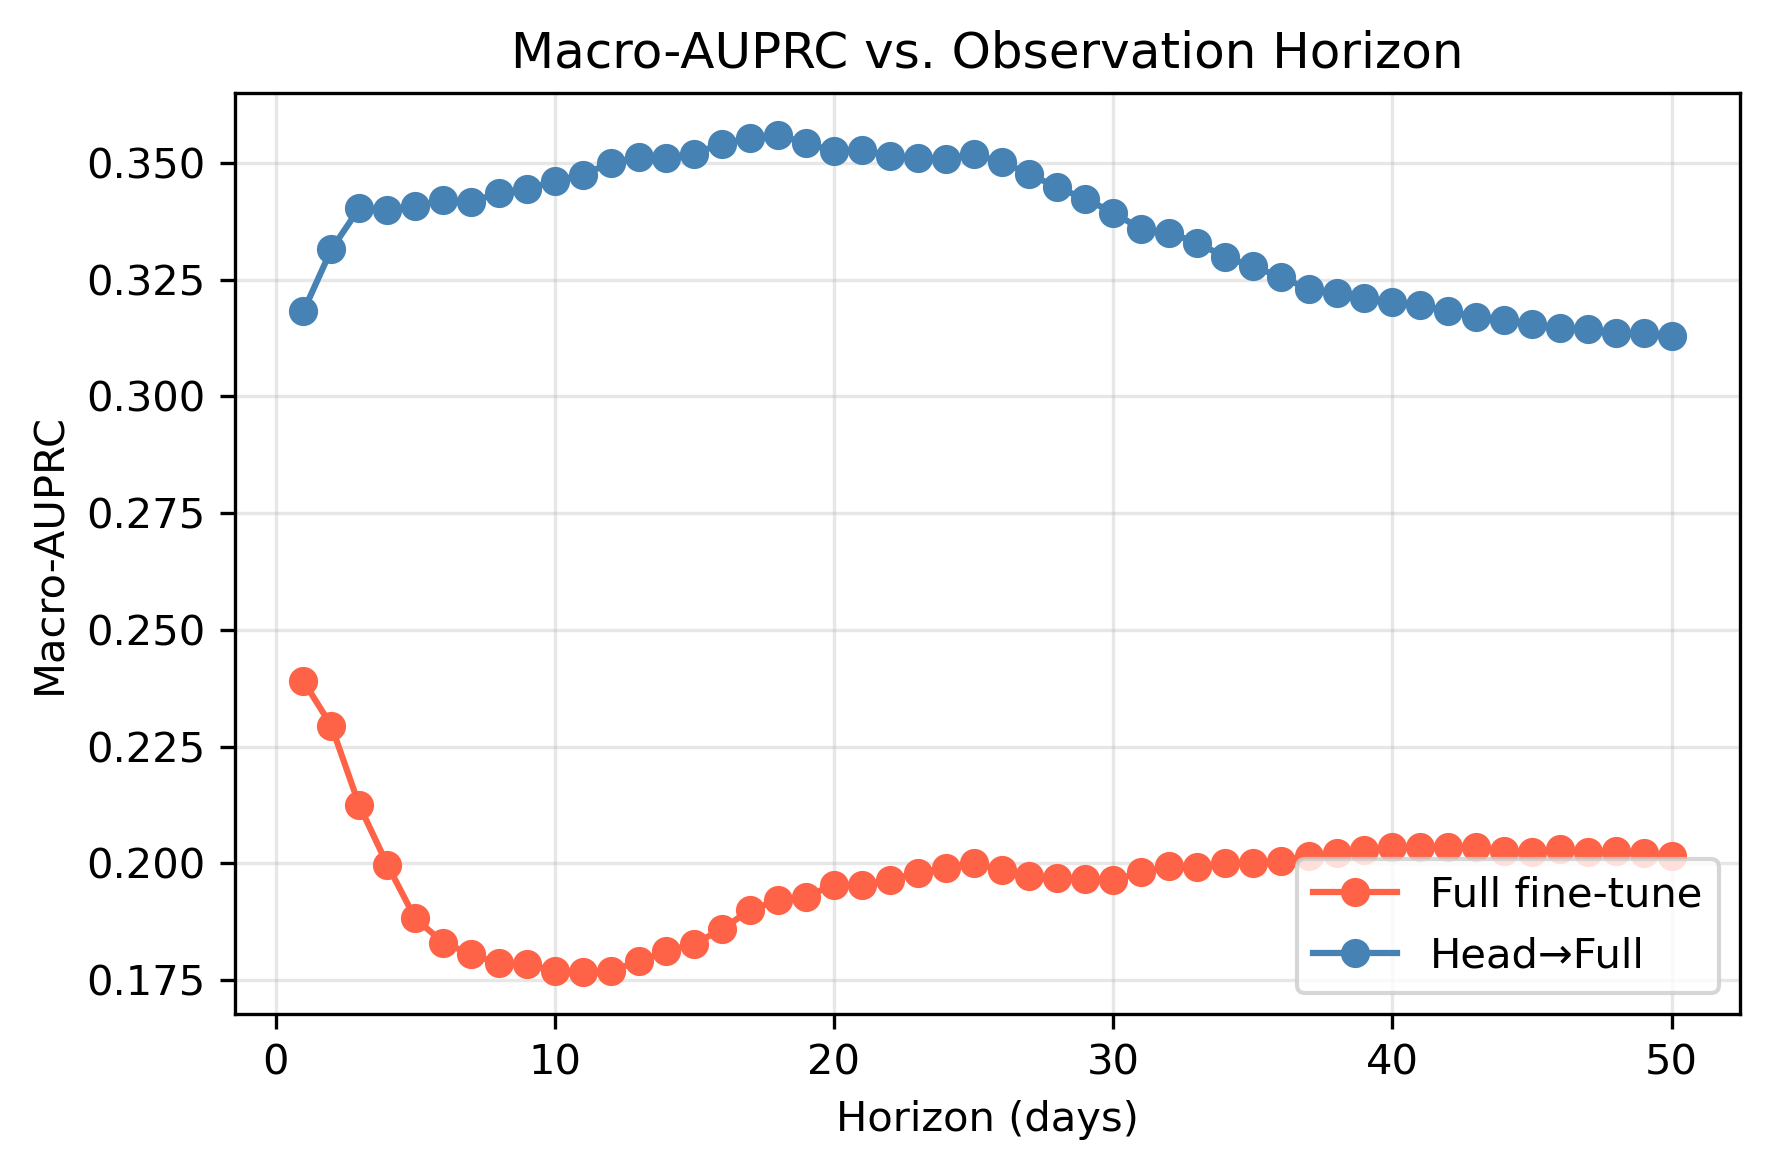

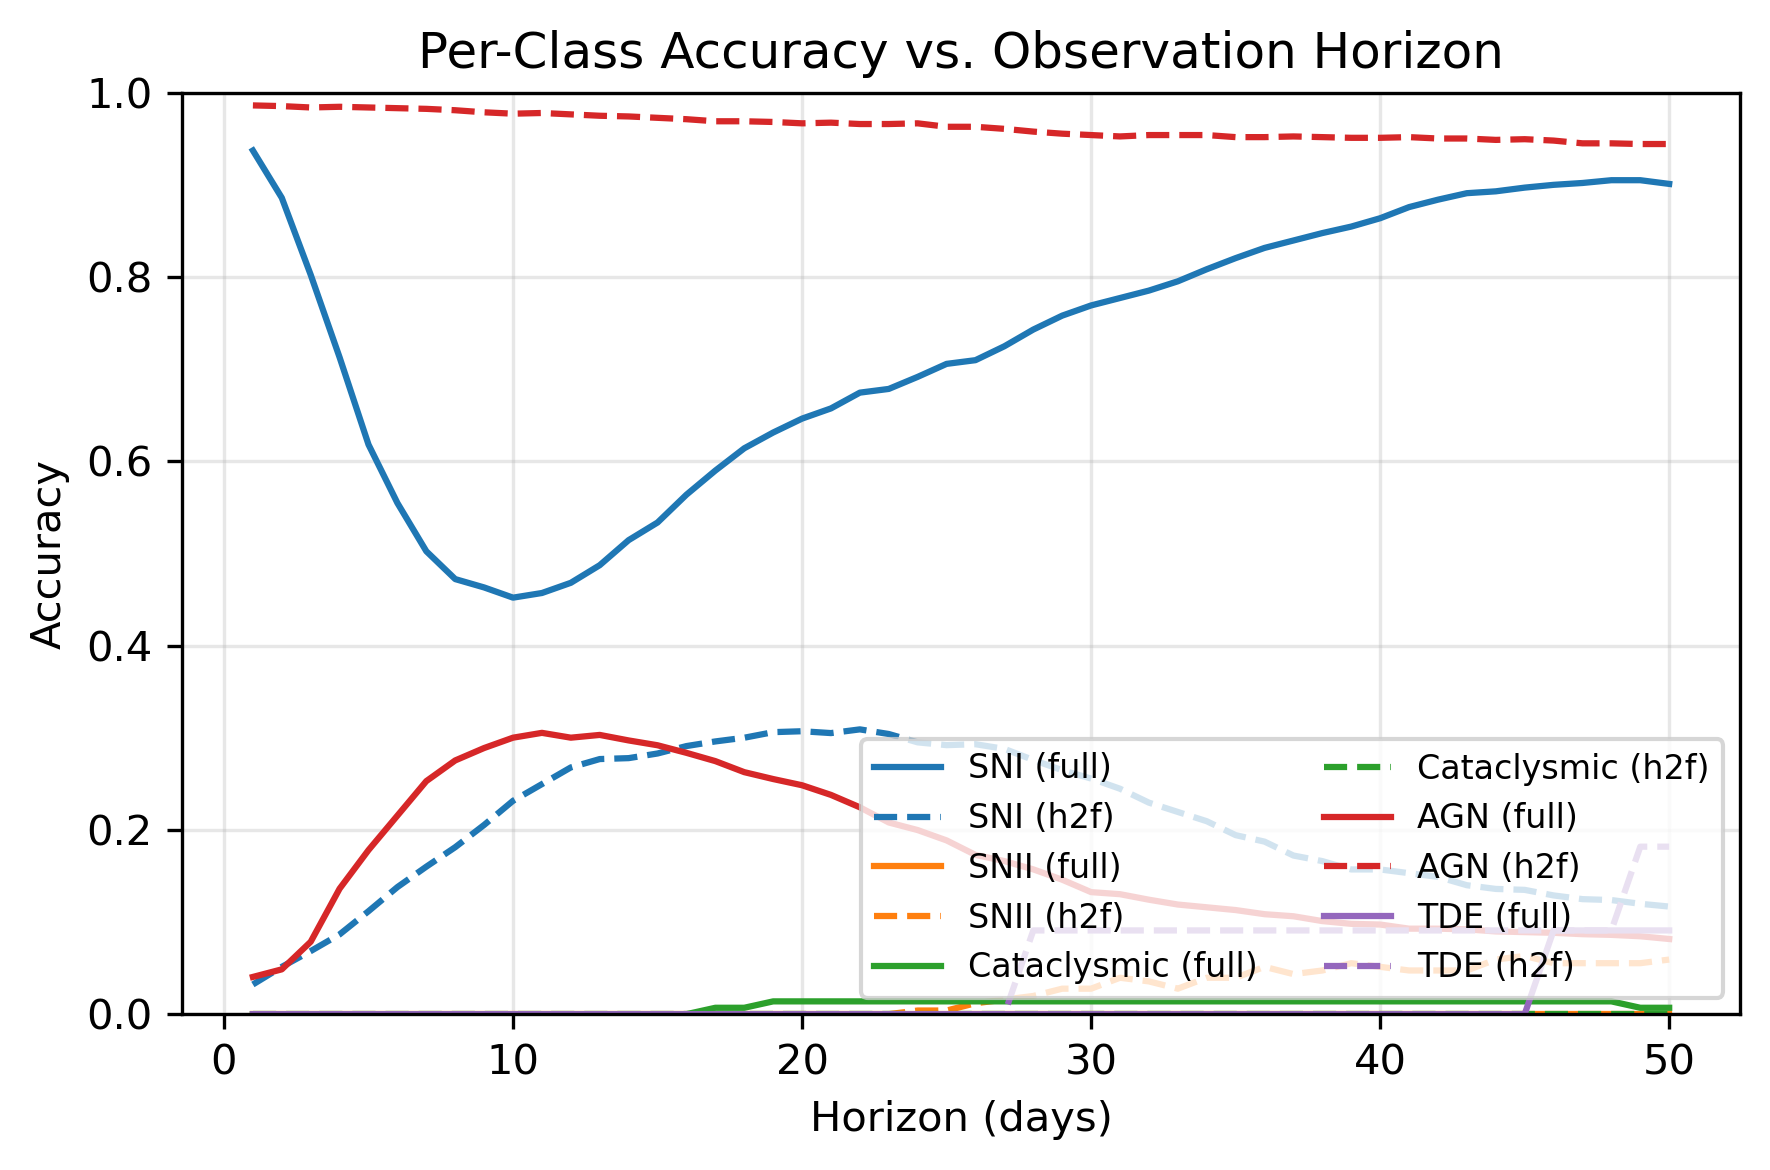

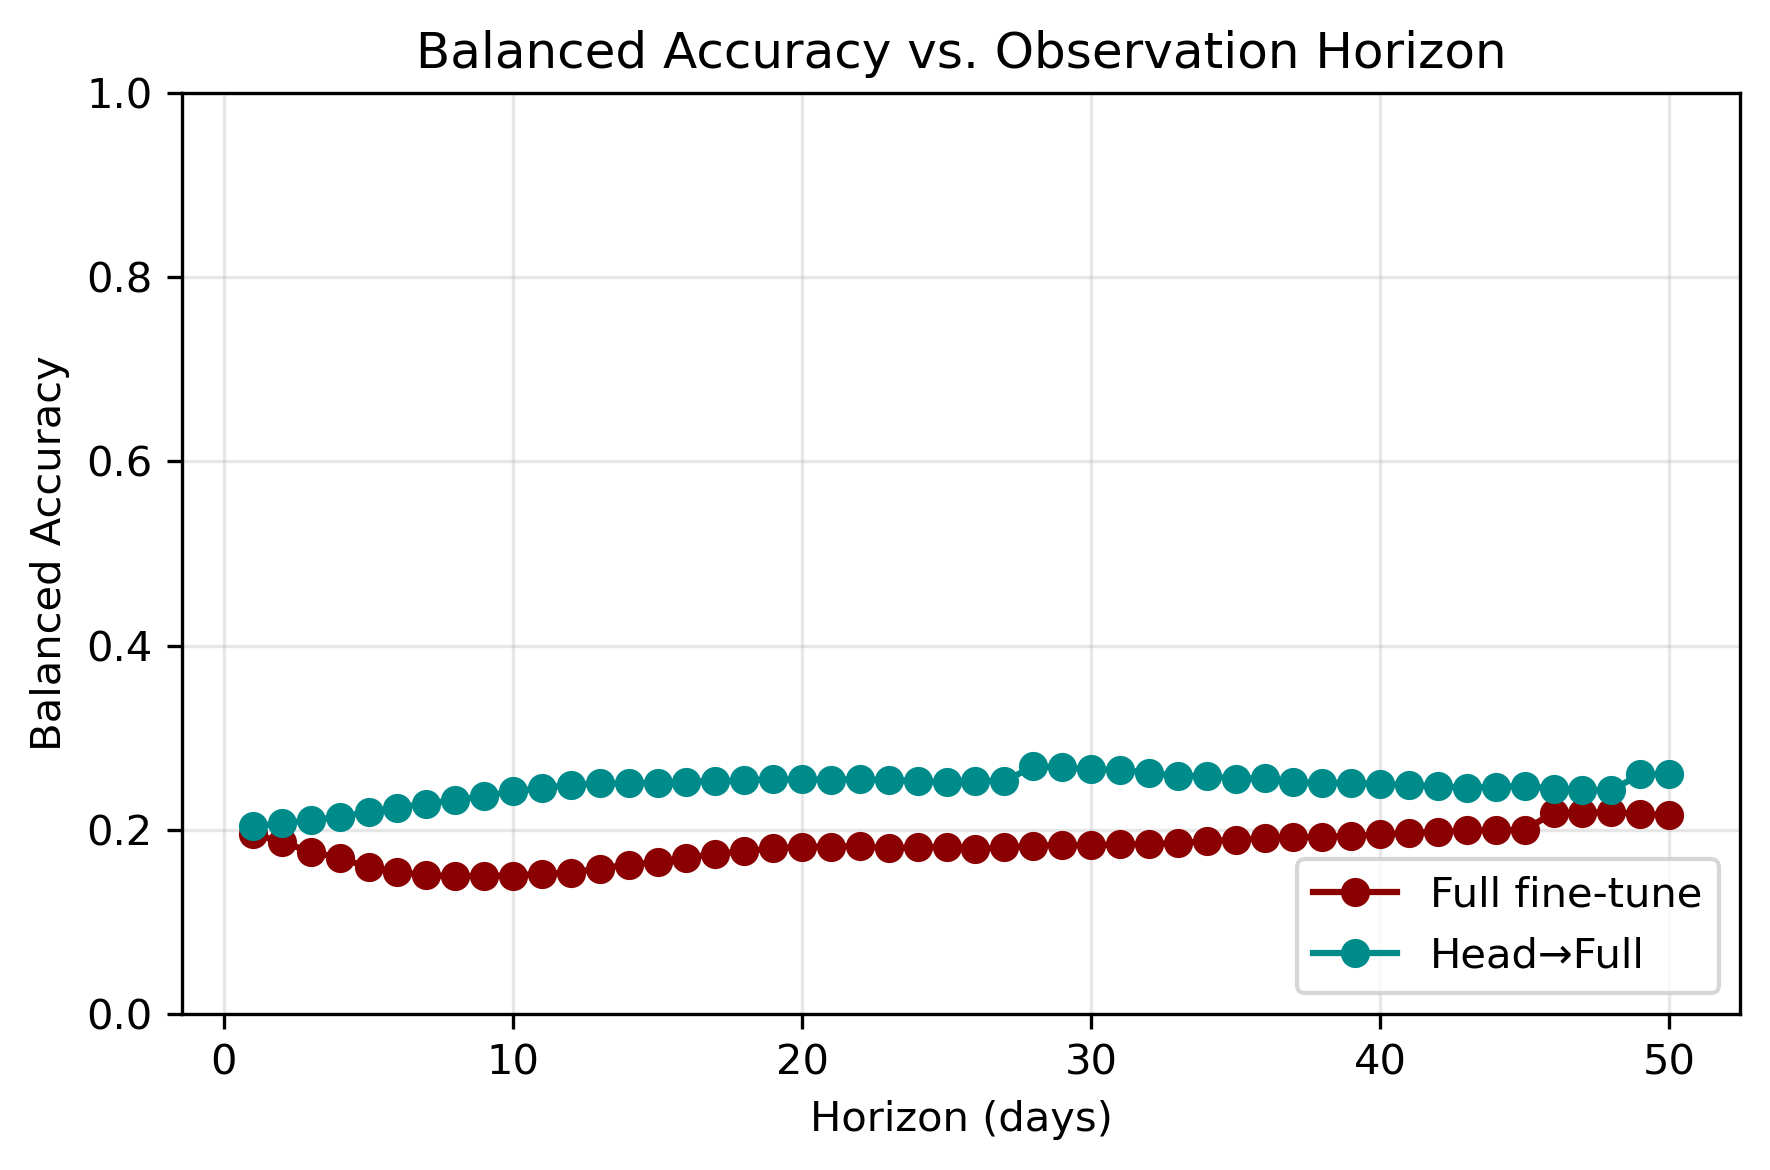

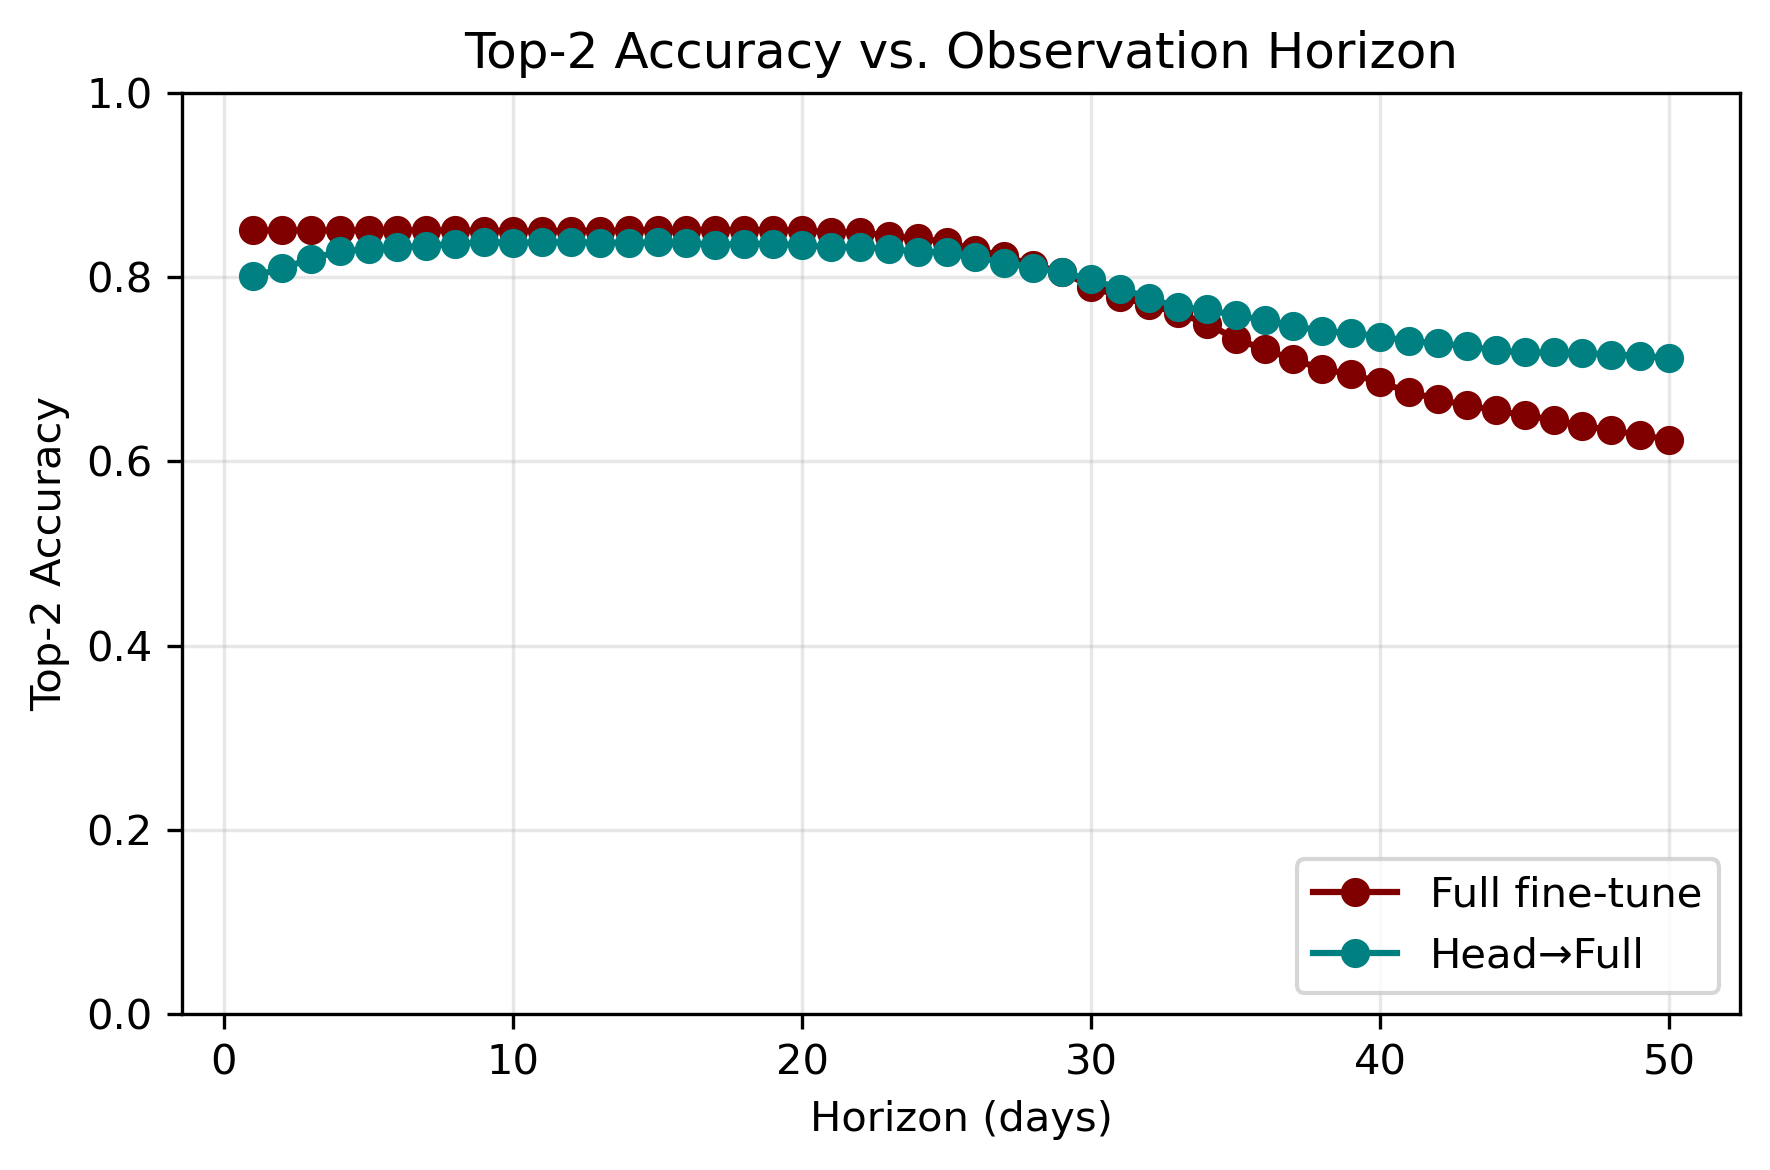

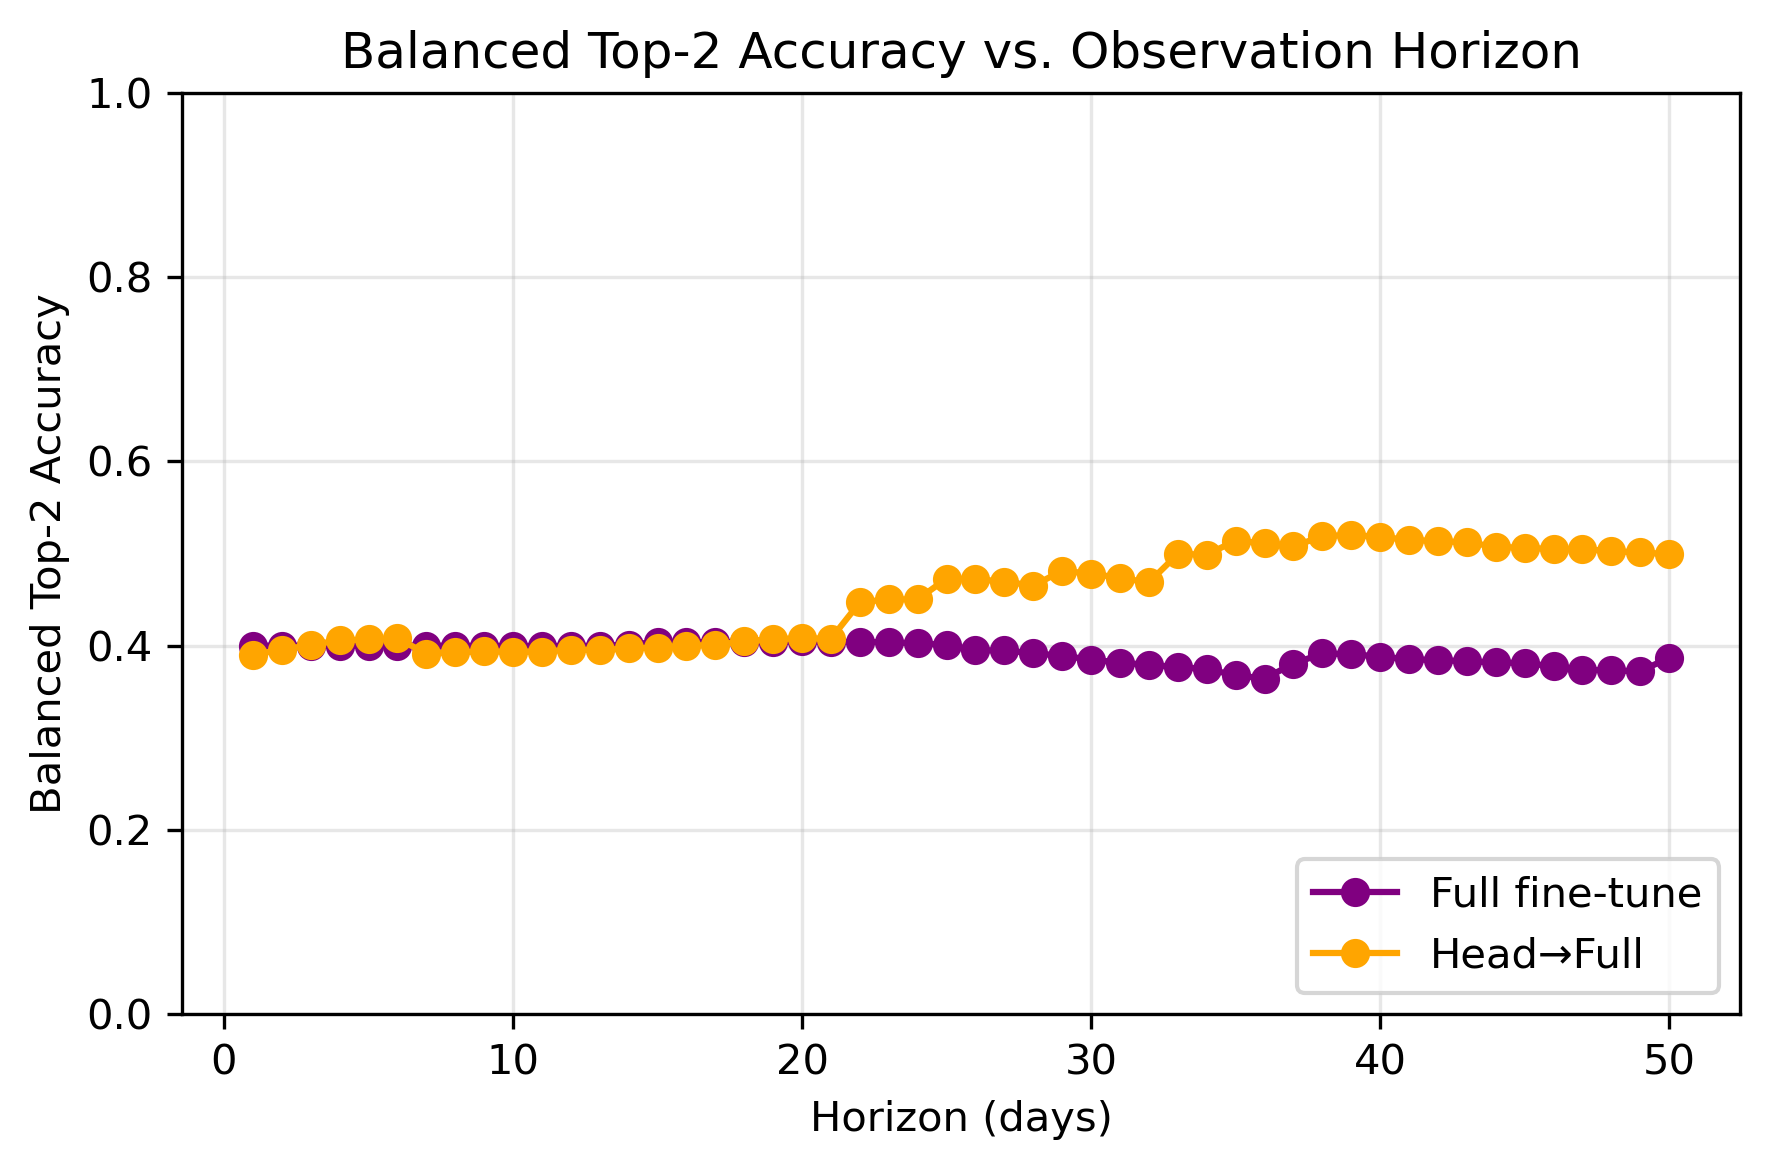

In [21]:
# --------- Macro‐AUPRC vs Horizon ----------------------------------------------
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
ax.plot(horizons, auprc_full, '-o', color='tomato',    label='Full fine-tune')
ax.plot(horizons, auprc_h2f,  '-o', color='steelblue', label='Head→Full')
ax.set(xlabel="Horizon (days)", ylabel="Macro-AUPRC",
       title="Macro-AUPRC vs. Observation Horizon")
ax.legend(loc='lower right'); ax.grid(alpha=0.3)
plt.tight_layout()
wandb.log({"horizon_macro_auprc": wandb.Image(fig)})
plt.show()
plt.close(fig)

# --------- Per‐Class Accuracy vs Horizon ---------------------------------------
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
for c, cls in enumerate(BROAD_CLASSES):
    ax.plot(horizons, accs_full[:, c],  '-',  color=f"C{c}", label=f"{cls} (full)")
    ax.plot(horizons, accs_h2f[:, c],   '--', color=f"C{c}", label=f"{cls} (h2f)")
ax.set(xlabel="Horizon (days)", ylabel="Accuracy",
       title="Per-Class Accuracy vs. Observation Horizon")
ax.set_ylim(0,1)
ax.legend(fontsize=8, ncol=2, loc='lower right'); ax.grid(alpha=0.3)
plt.tight_layout()
wandb.log({"horizon_per_class_acc": wandb.Image(fig)})
plt.show()
plt.close(fig)

# --------- Balanced Accuracy vs Horizon ----------------------------------------
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
ax.plot(horizons, balacc_full, '-o', color='darkred',  label='Full fine-tune')
ax.plot(horizons, balacc_h2f,  '-o', color='darkcyan', label='Head→Full')
ax.set(xlabel="Horizon (days)", ylabel="Balanced Accuracy",
       title="Balanced Accuracy vs. Observation Horizon")
ax.set_ylim(0,1)
ax.legend(loc='lower right'); ax.grid(alpha=0.3)
plt.tight_layout()
wandb.log({"horizon_balanced_acc": wandb.Image(fig)})
plt.show()
plt.close(fig)

# --------- Top-2 Accuracy vs Horizon -------------------------------------------
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
ax.plot(horizons, top2_full, '-o', color='maroon', label='Full fine-tune')
ax.plot(horizons, top2_h2f,  '-o', color='teal',   label='Head→Full')
ax.set(xlabel="Horizon (days)", ylabel="Top-2 Accuracy",
       title="Top-2 Accuracy vs. Observation Horizon")
ax.set_ylim(0,1)
ax.legend(loc='lower right'); ax.grid(alpha=0.3)
plt.tight_layout()
wandb.log({"horizon_top2_accuracy": wandb.Image(fig)})
plt.show()
plt.close(fig)

# --------- Balanced Top-2 Accuracy vs Horizon ---------------------------------
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
ax.plot(horizons, btop2_full, '-o', color='purple', label='Full fine-tune')
ax.plot(horizons, btop2_h2f,  '-o', color='orange', label='Head→Full')
ax.set(xlabel="Horizon (days)", ylabel="Balanced Top-2 Accuracy",
       title="Balanced Top-2 Accuracy vs. Observation Horizon")
ax.set_ylim(0,1)
ax.legend(loc='lower right'); ax.grid(alpha=0.3)
plt.tight_layout()
wandb.log({"horizon_bal_top2_accuracy": wandb.Image(fig)})
plt.show()
plt.close(fig)

wandb.finish()

In [22]:
# ===============================================================
#    Evaluation helpers  ----------------------------------------
# ===============================================================
def _threshold_sweep(y_true_oh, probs_dict, beta=2, n_points=101):
    rows=[]; th_vec=np.linspace(0,1,n_points); b2=beta**2
    for src,P in probs_dict.items():
        for c in range(P.shape[1]):
            y_c = y_true_oh[:,c]
            for thr in th_vec:
                y_hat=(P[:,c]>=thr).astype(int)
                tp=(y_hat&y_c).sum()
                fp=(y_hat&~y_c).sum()
                fn=(~y_hat&y_c).sum()
                prec=tp/(tp+fp+1e-9)
                rec =tp/(tp+fn+1e-9)
                f1  =2*prec*rec/(prec+rec+1e-9)
                fβ  =(1+b2)*prec*rec/(b2*prec+rec+1e-9)
                rows.append([BROAD_CLASSES[c],src,thr,prec,rec,f1,fβ])
    return pd.DataFrame(rows,columns=['Class','Source','Thr','Prec','Rec','F1','Fbeta'])

def pick_class_thresholds(df_sweep, beta=2, source="Phot"):
    b2=beta**2; tau={}
    for cls in BROAD_CLASSES:
        sub=df_sweep[(df_sweep.Class==cls)&(df_sweep.Source==source)]
        prec,rec=sub.Prec.values, sub.Rec.values
        fβ=(1+b2)*prec*rec/(b2*prec+rec+1e-9)
        tau[cls]=float(sub.iloc[fβ.argmax()].Thr)
    return tau

def predict_with_thresholds(probs, tau_dict):
    y_hat = probs.argmax(1)
    keep  = probs[np.arange(len(probs)), y_hat] >= np.vectorize(
                tau_dict.__getitem__)([BROAD_CLASSES[c] for c in y_hat])
    return np.where(keep, y_hat, -1)

def inference(model, loader):
    ys, ps = [], []
    model.eval()
    with torch.no_grad():
        for x,y,m in tqdm(loader, desc="INF", leave=False):
            x,m = x.to(device), m.to(device)
            logits = model(x,m)
            probs  = torch.softmax(logits,1).cpu().numpy()
            ys.append(y.numpy()); ps.append(probs)
    return np.concatenate(ys), np.concatenate(ps)

def evaluate(model, loader, split, ckpt_path, tau_per_class=None, beta=2, return_tau=False):
    # load best weights
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    y, p = inference(model, loader)
    print("y:", y)
    print("p:", p)
    y_onehot = label_binarize(y, classes=np.arange(NUM_CLASSES))

    # threshold sweep
    df_sweep = _threshold_sweep(y_onehot, {"Phot": p}, beta=beta)

    # learn τ⋆ on val
    if tau_per_class is None and split=="val":
        tau_per_class = pick_class_thresholds(df_sweep, beta=beta, source="Phot")

    # naive + thresholded preds
    y_naive = p.argmax(1)
    y_thr   = predict_with_thresholds(p, tau_per_class) if tau_per_class else None

    # --- sweep plots ---
    fig_thr, axes = plt.subplots(NUM_CLASSES,1,
                                 figsize=(9,2.4*NUM_CLASSES),dpi=300,sharex=True)
    for ax,cls in zip(axes,BROAD_CLASSES):
        sub = df_sweep[df_sweep.Class==cls]
        for src,grp in sub.groupby('Source'):
            ax.plot(grp.Thr, grp.Fbeta,    label=f"F{beta}-{src}", color="#1f77b4", lw=2)
            ax.plot(grp.Thr, grp.Prec,  ls='--', lw=1, color="#1f77b4", alpha=.7)
            ax.plot(grp.Thr, grp.Rec,   ls=':',  lw=1, color="#1f77b4", alpha=.7)
            bi = grp.Fbeta.idxmax()
            ax.scatter(grp.loc[bi,'Thr'], grp.loc[bi,'Fbeta'], color="#1f77b4", s=30)
        ax.set_title(cls, loc='left'); ax.set_ylabel(f"Score (F{beta})")
        ax.set_xlim(0,1); ax.set_ylim(0,1.02); ax.legend(frameon=False, fontsize=7)
    axes[-1].set_xlabel("Decision threshold")
    plt.tight_layout()
    wandb.log({f'{split}/thr_sweep': wandb.Image(fig_thr)})
    #plt.close(fig_thr)
    plt.show()

    # --- confusion matrix ---
    
    cm      = confusion_matrix(y, y_naive)
    print("confusion matrix", cm)
    cm_norm = (cm.astype(float)/cm.sum(axis=1,keepdims=True))
    cm_norm[np.isnan(cm_norm)] = 0
    def _plot_cm(mat, ax, title, cmap, fmt):
        im = ax.imshow(mat, cmap=cmap, vmin=0, vmax=(mat.max() if fmt=='d' else 1))
        ax.set_title(title); ax.set_xticks(range(NUM_CLASSES)); ax.set_yticks(range(NUM_CLASSES))
        ax.set_xticklabels(BROAD_CLASSES, rotation=45, ha='right')
        ax.set_yticklabels(BROAD_CLASSES)
        for i in range(NUM_CLASSES):
            for j in range(NUM_CLASSES):
                txt = format(mat[i,j], fmt)
                ax.text(j,i,txt,ha='center',va='center',
                        color='white' if (mat.max() if fmt=='d' else 0.5)<im.norm(mat[i,j]) else 'black')
    fig_cm, axs_cm = plt.subplots(1,2,figsize=(14,5),dpi=300)
    _plot_cm(cm, axs_cm[0], f'{split} Conf (raw)',        'Reds','d')
    _plot_cm(cm_norm,axs_cm[1], f'{split} Conf (norm)',   'Blues','.2f')
    plt.tight_layout()
    wandb.log(wandb.Image(fig_cm))
    plt.show()
    #wandb.log({f'{split}/conf_mats': wandb.Image(fig_cm)})
    #plt.close(fig_cm)

    # --- ROC + PR curves ---
    fig_curv, (ax_roc,ax_pr) = plt.subplots(1,2,figsize=(14,6),dpi=300)
    colors = plt.get_cmap('Dark2').colors
    for i,cls in enumerate(BROAD_CLASSES):
        fpr,tpr,_ = roc_curve(y_onehot[:,i], p[:,i])
        prec,rec,_= precision_recall_curve(y_onehot[:,i], p[:,i])
        ax_roc.plot(fpr,tpr, color=colors[i], alpha=.9)
        ax_pr.step(rec,prec, where='post', color=colors[i], alpha=.9)
    # micro + macro
    fpr_m,tpr_m,_   = roc_curve(y_onehot.ravel(), p.ravel())
    prec_m,rec_m,_  = precision_recall_curve(y_onehot.ravel(), p.ravel())
    ax_roc.plot(fpr_m,tpr_m,'k:', lw=2.5)
    ax_pr.step(rec_m,prec_m,'k:',where='post', lw=2.5)
    # macro
    fpr_lin  = np.linspace(0,1,500)
    tpr_lin  = np.mean([np.interp(fpr_lin,*roc_curve(y_onehot[:,i],p[:,i])[:2])
                        for i in range(NUM_CLASSES)],axis=0)
    prec_lin = np.linspace(0,1,1000)
    pr_lin   = np.mean([np.interp(prec_lin,
                        precision_recall_curve(y_onehot[:,i],p[:,i])[1][::-1],
                        precision_recall_curve(y_onehot[:,i],p[:,i])[0][::-1])
                        for i in range(NUM_CLASSES)],axis=0)
    ax_roc.plot(fpr_lin,tpr_lin,'k', lw=2.7)
    ax_pr.step(prec_lin,pr_lin,'k',where='post',lw=2.7)
    for ax in (ax_roc,ax_pr):
        ax.set_xlim(-0.02,1.02); ax.set_ylim(-0.02,1.02)
        ax.xaxis.set_minor_locator(AutoMinorLocator()); ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(direction='in', length=6, which='major')
        ax.tick_params(direction='in', length=4, which='minor')
    ax_roc.set_xlabel('FPR'); ax_roc.set_ylabel('TPR'); ax_roc.plot([0,1],[0,1],'k--',alpha=.6, lw=.8)
    ax_pr.set_xlabel('Recall'); ax_pr.set_ylabel('Precision')
    ax_roc.legend(loc="best")
    plt.tight_layout()
    wandb.log({f'{split}/roc_pr_curves': wandb.Image(fig_curv)})
    plt.close(fig_curv)
    
    # --- TDE-only AUPRC ---------------------------------------
    # one-vs-all average precision for the TDE class
    tde_idx    = BROAD_CLASSES.index("TDE")
    y_tde      = (y == tde_idx).astype(int)
    tde_auprc  = average_precision_score(y_tde, p[:, tde_idx])
    wandb.log({f"{split}/auprc_TDE": tde_auprc})

    
    # --- bar chart vs. stratified baseline -------------------
    # build stratified baseline by sampling according to class priors
    support      = np.bincount(y, minlength=NUM_CLASSES)
    priors       = support / support.sum()
    rng          = np.random.default_rng(0)
    y_strat      = rng.choice(NUM_CLASSES, size=len(y), p=priors)
    y_prob_strat = np.tile(priors, (len(y),1))

    # collect metrics
    metrics_model = {
        "Accuracy":        (y_naive == y).mean(),
        "Top-2 Acc":       top_k_accuracy_score(y, p, k=2),
        "Macro Prec":      precision_score(y, y_naive, average="macro"),
        "Macro Rec":       recall_score(y, y_naive, average="macro"),
        "Macro F1":        f1_score(y, y_naive, average="macro"),
        "Macro AUPRC":     average_precision_score(y_onehot, p, average="macro"),
        "TDE AUPRC":       tde_auprc,
    }
    # --- stratified‐baseline metrics  ---
    classes = np.arange(NUM_CLASSES)
    # one‐hot ground truth for TDE‐AUPRC
    y_tde   = (y == tde_idx).astype(int)

    metrics_base = {
        k: (
            {
              "Accuracy":    lambda: (y_strat == y).mean(),
              "Top-2 Acc":   lambda: top_k_accuracy_score(y, y_prob_strat, k=2),
              "Macro Prec":  lambda: precision_score(y, y_strat, average="macro"),
              "Macro Rec":   lambda: recall_score(y, y_strat, average="macro"),
              "Macro F1":    lambda: f1_score(y, y_strat, average="macro"),
              "Macro AUPRC": lambda: average_precision_score(
                                   label_binarize(y, classes=classes),
                                   y_prob_strat,
                                   average="macro"),
              "TDE AUPRC":   lambda: average_precision_score(
                                   y_tde,
                                   y_prob_strat[:, tde_idx]),
            }[k]()
        )
        for k in metrics_model
    }

    names  = list(metrics_model.keys())
    vals_m = [metrics_model[n] for n in names]
    vals_b = [metrics_base[n]  for n in names]

    fig, ax = plt.subplots(figsize=(8,4), dpi=100)
    x = np.arange(len(names))
    w = 0.35
    ax.bar(x-w/2, vals_b, w, label="Stratified", color="gray", alpha=0.7)
    ax.bar(x+w/2, vals_m, w, label="Model",      color=plt.get_cmap("tab10")(0))
    ax.set_xticks(x); ax.set_xticklabels(names, rotation=25, ha="right")
    ax.set_ylim(0,1.05); ax.set_ylabel("Score"); ax.set_title(f"{split}: Model vs Baseline")
    ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    wandb.log({f"{split}/baseline_comparison": wandb.Image(fig)})
    #plt.close(fig)
    plt.show()
    
    # --- per-class confidence distributions ---------------
    # how confident is the model on its *true* class?
    bins = np.linspace(0,1,30)
    fig, axes = plt.subplots(NUM_CLASSES,1, figsize=(6,2.2*NUM_CLASSES), dpi=100, sharex=True)
    for i, cls in enumerate(BROAD_CLASSES):
        sub_probs = p[y==i, i]
        sns.histplot(sub_probs, bins=bins, stat="density", kde=True,
                     ax=axes[i], color=plt.get_cmap("tab10")(i), alpha=0.6)
        axes[i].set_xlim(0,1)
        axes[i].set_ylabel("Density")
        axes[i].set_title(f"{cls}: P(model predicts true class)")
    axes[-1].set_xlabel("Predicted probability")
    plt.tight_layout()
    #plt.close(fig)
    plt.show()
    
    # --- bar chart vs stratified baseline ---
    support = np.bincount(y, minlength=NUM_CLASSES)
    priors  = support/support.sum()
    rng     = np.random.default_rng(0)
    y_strat = rng.choice(NUM_CLASSES, size=len(y), p=priors)
    y_prob_strat = np.tile(priors,(len(y),1))

    # collect scalar metrics
    f1_m   = f1_score(y, y_naive, average='macro')
    prec_m = precision_score(y,y_naive, average='macro')
    rec_m  = recall_score(y,y_naive, average='macro')
    auprc  = average_precision_score(y_onehot, p, average='macro')
    top2   = top_k_accuracy_score(y,p,k=2)
    top3   = top_k_accuracy_score(y,p,k=3)
    f2_naive = fbeta_score(y,y_naive,average='macro',beta=2)
    f2_thr   = (fbeta_score(y[y_thr!=-1],y_thr[y_thr!=-1],average='macro',beta=2)
                if y_thr is not None else None)

    wandb.log({
        f"{split}/acc":               (y_naive==y).mean(),
        f"{split}/top2_acc":          top2,
        f"{split}/top3_acc":          top3,
        f"{split}/precision_macro":   prec_m,
        f"{split}/recall_macro":      rec_m,
        f"{split}/f1_macro":          f1_m,
        f"{split}/auprc_macro":       auprc,
        f"{split}/f2_naive":          f2_naive,
        f"{split}/f2_thresholded":    f2_thr,
    })

    if return_tau and split=="val":
        return tau_per_class



In [23]:
# ===============================================================
#      Main & training + evaluation  ----------------------------
# ===============================================================
def main(cfg):
    # W&B init
    wandb.init(project="apple_photo", config=cfg.__dict__)
    ckpt_path = "best_newtrans_baseline.pt"

    # data
    out      = Path(cfg.output_dir)
    train_df = pd.read_csv(out/'manifest_train.csv')
    #val_df   = pd.read_csv(out/'manifest_val.csv')
    test_df  = pd.read_csv(out/'manifest_test.csv')

    #train_ds = PhotoEventDataset(train_df, cfg.horizon_days)
    #val_ds   = PhotoEventDataset(val_df,   cfg.horizon_days)
    test_ds  = PhotoEventDataset(test_df,  cfg.horizon_days)

    mean,std = load_stats(out/cfg.stats_file)
    collate  = build_collate(mean, std)

    #if cfg.sampler_balance:
    #    lbl     = train_df.label.map(ID2BROAD_ID).values
    #    weights = 1/np.sqrt(np.bincount(lbl,minlength=NUM_CLASSES))[lbl]
    #    sampler = WeightedRandomSampler(torch.from_numpy(weights).float(),
    #                                    len(weights), replacement=True)
    #    train_ld= DataLoader(train_ds, batch_size=cfg.batch_size,
    #                         sampler=sampler, num_workers=cfg.num_workers,
    #                         collate_fn=collate, pin_memory=True)
    #else:
    #    train_ld= DataLoader(train_ds, batch_size=cfg.batch_size,
    #                         shuffle=True, num_workers=cfg.num_workers,
    #                         collate_fn=collate, pin_memory=True)
    #val_ld   = DataLoader(val_ds,   batch_size=cfg.batch_size,
    #                      shuffle=False, num_workers=cfg.num_workers,
    #                      collate_fn=collate, pin_memory=True)
    
    print("DataLoader")
    test_ld  = DataLoader(test_ds,  batch_size=cfg.batch_size,
                          shuffle=False, num_workers=cfg.num_workers,
                          collate_fn=collate, pin_memory=True)
    print("model")
    # model, loss, optim, sched
    model = BaselineCLS(cfg.d_model,cfg.n_heads,cfg.n_layers,
                        NUM_CLASSES,cfg.dropout,cfg.max_len).to(device)
    cnts  = torch.bincount(torch.tensor(train_df.label.map(ID2BROAD_ID).values),
                           minlength=NUM_CLASSES)
    alpha = (1/torch.sqrt(cnts+1e-6)).to(device)
    # crit  = FocalLoss(cfg.focal_gamma, alpha)
    crit  = FocalLoss(cfg.focal_gamma, None)
    opt   = torch.optim.AdamW(model.parameters(), lr=cfg.lr,
                              weight_decay=cfg.weight_decay)

    # training loop
    best_auprc = 0.0
    patience    = 0

    #for ep in range(1, CFG.epochs+1):
    #    train_loss, train_acc, train_auprc = run_epoch(model, train_ld, opt, crit, is_train=True)
    #    val_loss,   val_acc,   val_auprc   = run_epoch(model,   val_ld,   None, crit, is_train=False)
#
    #    # log everything to W&B
    #    wandb.log({
    #        "train/loss": train_loss,
    #        "train/acc":  train_acc,
    #        "train/auprc":train_auprc,
    #        "val/loss":   val_loss,
    #        "val/acc":    val_acc,
    #        "val/auprc":  val_auprc,
    #    }, step=ep)
#
    #    # early stopping on macro-AUPRC
    #    if val_auprc > best_auprc + 1e-4:
    #        best_auprc, patience = val_auprc, 0
    #        torch.save(model.state_dict(), ckpt_path)
    #    else:
    #        patience += 1
    #        if patience >= CFG.patience:
    #            print(f"Stopping early at epoch {ep}, best val AUPRC={best_auprc:.4f}")
    #            break
#
    #    print(f"EP{ep:02d} | "
    #          f"tr loss {train_loss:.3f} acc {train_acc:.3f} AUPRC {train_auprc:.3f} | "
    #          f"va loss {val_loss:.3f} acc {val_acc:.3f} AUPRC {val_auprc:.3f}")
    ## --- final evaluation on val & test -------------------------
    #tau_star = evaluate(model, val_ld,   "val",   ckpt_path, return_tau=True)
    
    print("evaluate")
    evaluate(model, test_ld, "test", 
             ckpt_path='/projects/bcrv/abrown3/AppleCiDEr_Skyportal/pt/ft_head_then_full.pt',
             tau_per_class=None)

    wandb.finish()

# if __name__ == "__main__":
#     main(CFG)


DataLoader
model
evaluate


/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/tmp/ipykernel_2862768/534766822.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be execu

INF:   0%|          | 0/11 [00:00<?, ?it/s]

y: [3 0 3 ... 3 3 1]
p: [[1.7437625e-03 1.2564398e-02 2.1070391e-03 3.0535826e-01 6.7822653e-01]
 [6.8250990e-01 3.1682408e-01 9.2215254e-05 4.9920293e-04 7.4680473e-05]
 [1.4506098e-03 8.8773798e-03 1.0585112e-02 9.4101810e-01 3.8068812e-02]
 ...
 [4.9707647e-02 2.9109621e-02 3.1488058e-01 6.0485303e-01 1.4490993e-03]
 [5.8935940e-02 3.1388126e-02 6.7600757e-01 2.3306556e-01 6.0283270e-04]
 [5.8297463e-02 9.1776961e-01 1.2752764e-04 2.0589216e-02 3.2161917e-03]]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9cea2c310>
Traceback (most recent call last):
  File "/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/u/abrown3/envapple/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u/abrown3/envapple/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/u/abrown3/envapple/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/u/abrown3/envapple/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/u/abrown3/envapple/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


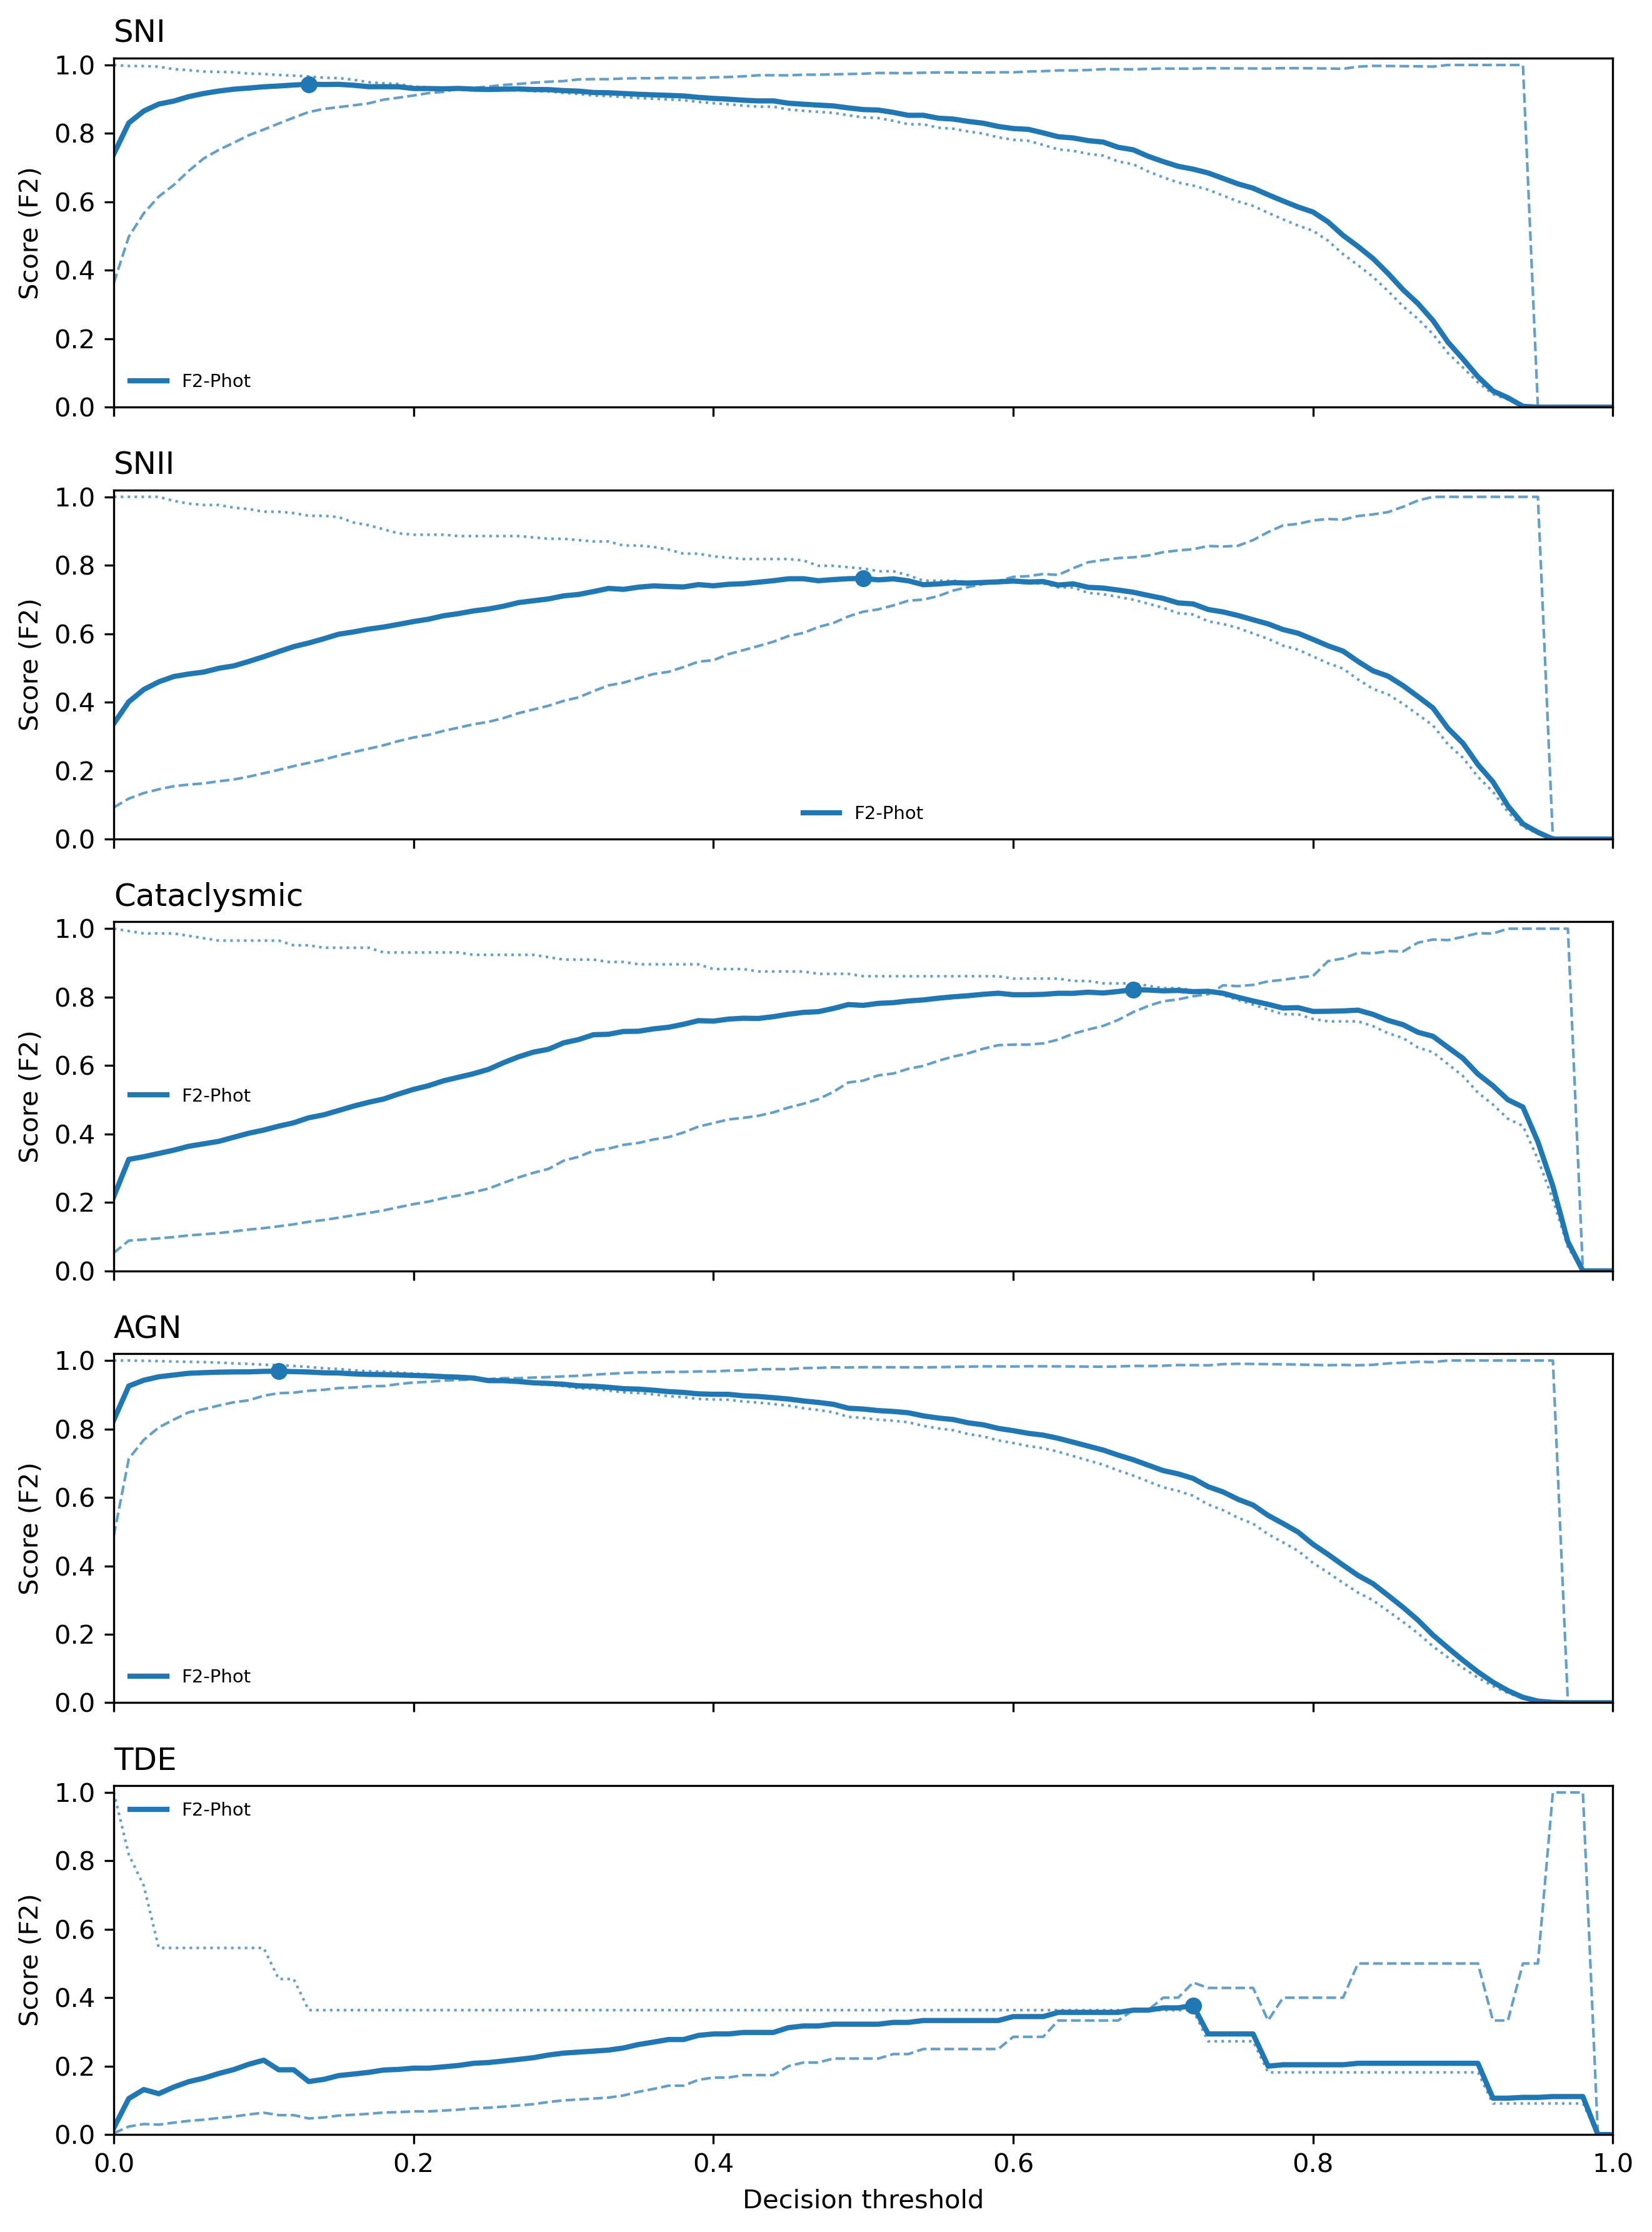

confusion matrix [[ 857   75   40   18    3]
 [  22  204   12   12    3]
 [   3    2  129    9    1]
 [   4   53   92 1171   16]
 [   0    1    3    3    4]]


ValueError: wandb.log must be passed a dictionary

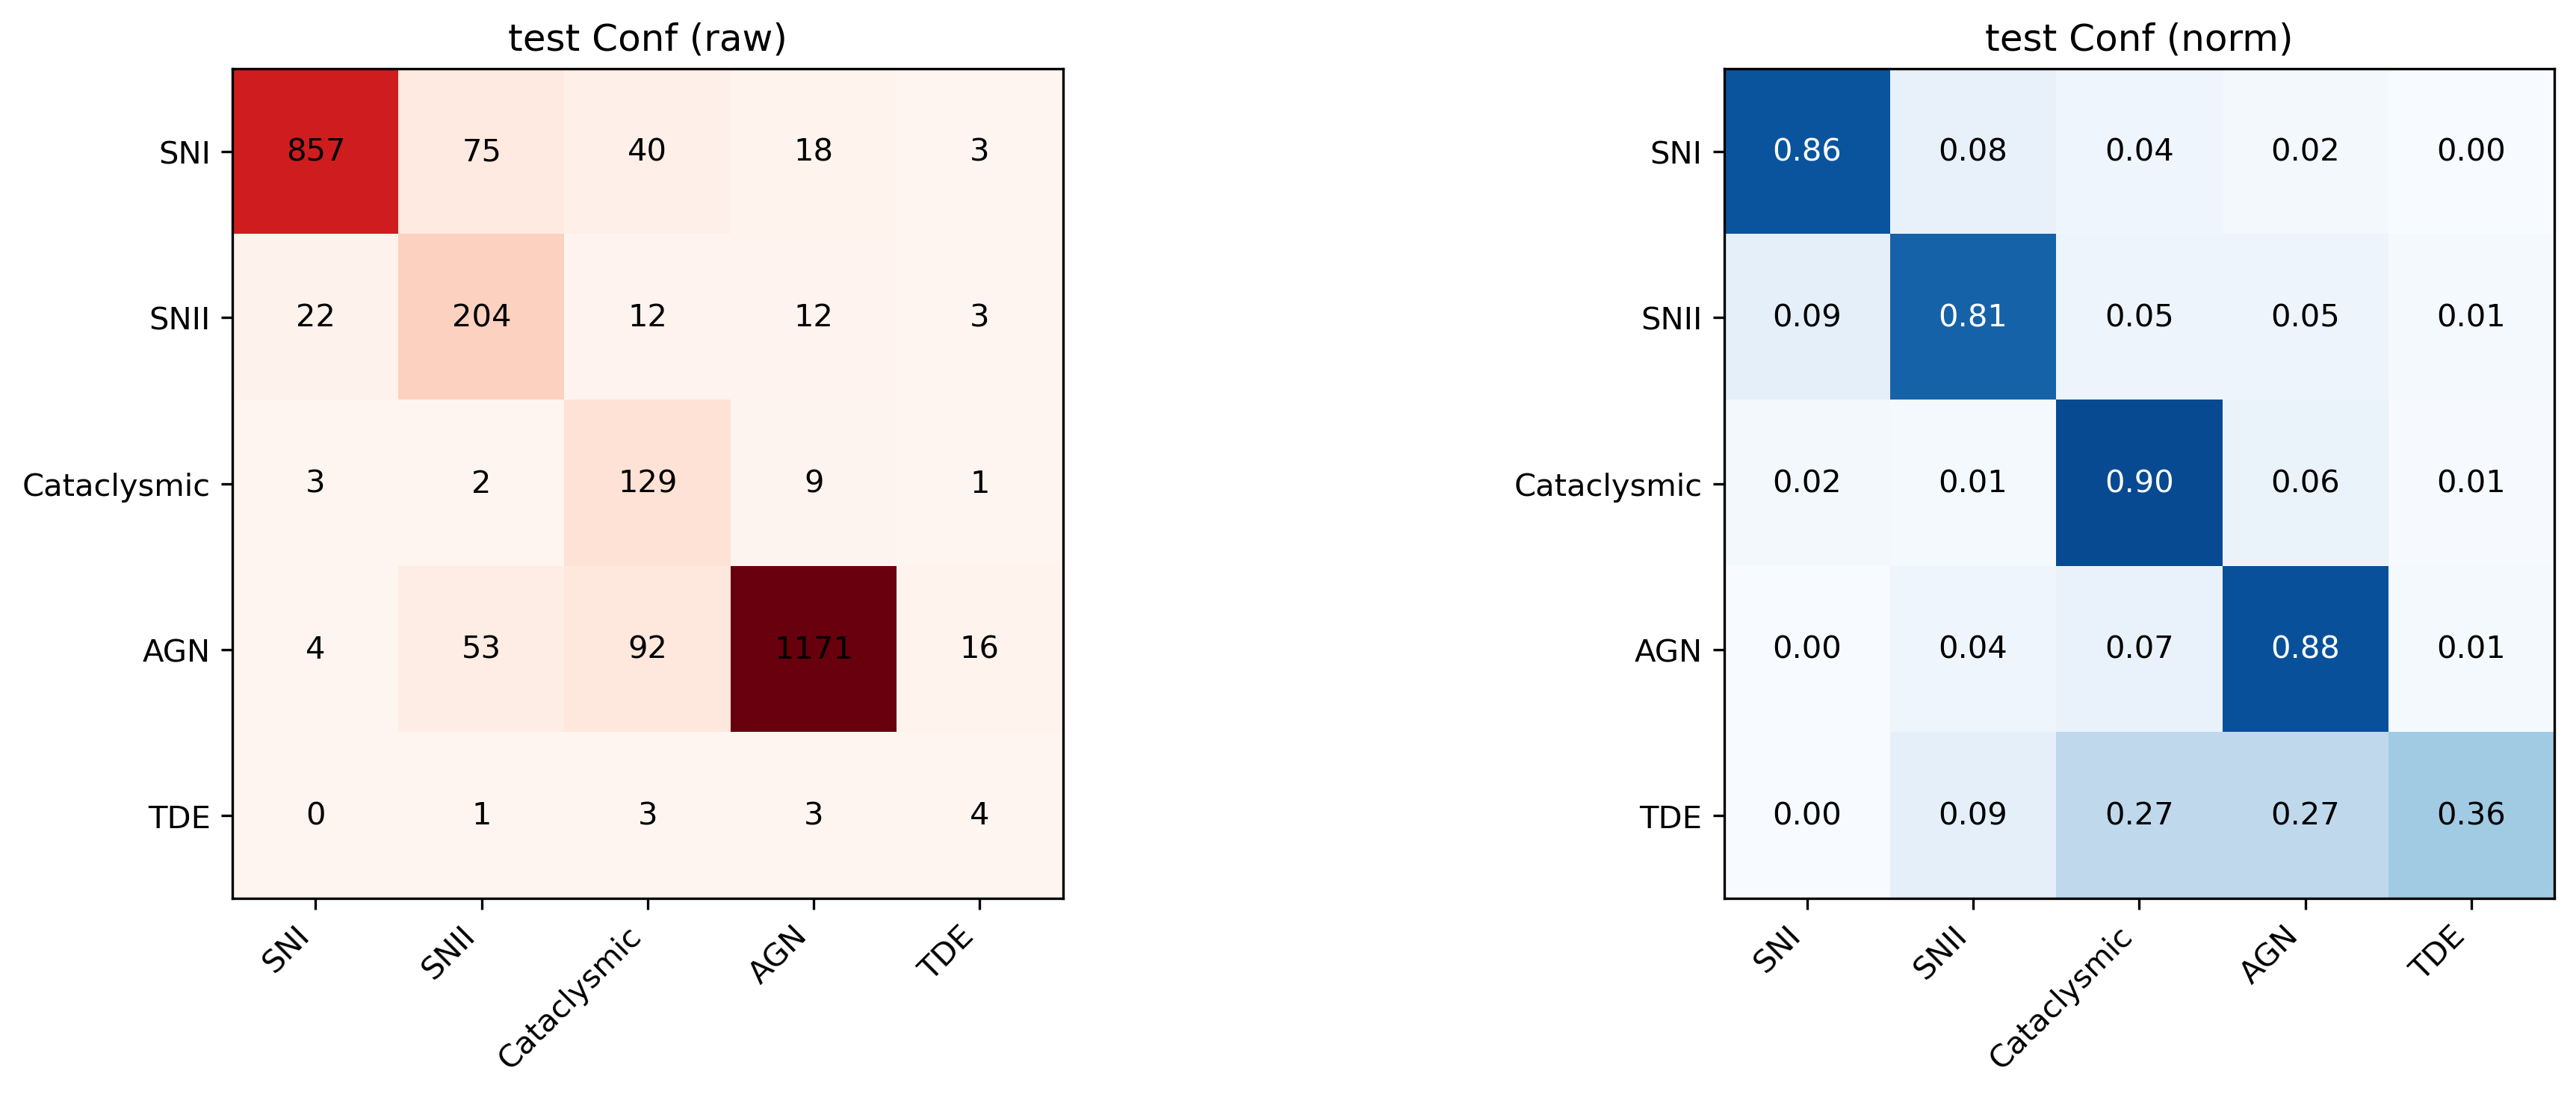

In [24]:
main(CFG)